In [1]:
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Dense,
    Input,
    Dropout,
    Activation,
    Flatten,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
)
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import train_test_split

seed = 7
np.random.seed(seed)


warnings.simplefilter("ignore")

In [9]:
digits = pd.read_csv("train.csv")

labels = digits["label"]
digits = np.array(digits.drop("label", axis=1)).astype("float")
digits.shape, labels.shape

((42000, 784), (42000,))

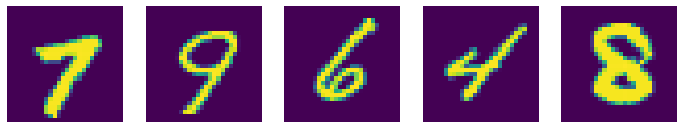

In [10]:
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(random.choice(digits).reshape(28, 28))
    plt.axis("off")

In [11]:
split = 0.7, 0.3  # train, test
# normalize data
digits /= 255.0

split_ind = int(len(digits) * split[0])
X_train, X_test, y_train, y_test = (
    digits[:split_ind],
    digits[split_ind:],
    labels[:split_ind],
    labels[split_ind:],
)
X_train.shape, X_test.shape

((29399, 784), (12601, 784))

In [12]:
model = MLPClassifier().fit(X_train, y_train)
y_pred = model.predict(X_test)

print(
    f"Using MLPClassifier with the default parameter values gives an accuracy of {accuracy_score(y_pred, y_test)}"
)

Using MLPClassifier with the default parameter values gives an accuracy of 0.9637330370605508


In [13]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1273
           1       0.99      0.97      0.98      1438
           2       0.96      0.97      0.96      1202
           3       0.95      0.97      0.96      1293
           4       0.98      0.95      0.96      1216
           5       0.97      0.92      0.95      1195
           6       0.94      0.99      0.97      1169
           7       0.97      0.97      0.97      1335
           8       0.96      0.95      0.95      1256
           9       0.93      0.96      0.94      1224

    accuracy                           0.96     12601
   macro avg       0.96      0.96      0.96     12601
weighted avg       0.96      0.96      0.96     12601



In [14]:
parameters = {
    "hidden_layer_sizes": [50, 100, 200],
    "alpha": [0.001, 0.01, 0.1],
    "max_iter": [200, 500, 800],
    "learning_rate_init": [0.0001, 0.001, 0.01, 0.1],
}

model = MLPClassifier()
clf = RandomizedSearchCV(estimator=model, param_distributions=parameters, cv=5)
clf.fit(
    X_train[:3000], y_train[:3000]
)  # reduce the train set size to shorten the training time

print("The best parameter values found are:\n")
print(clf.best_params_)

# store the best model found in "bestmodel"
bestmodel = clf.best_estimator_

The best parameter values found are:

{'max_iter': 500, 'learning_rate_init': 0.01, 'hidden_layer_sizes': 100, 'alpha': 0.001}


The accuracy score of the best model is 0.9331799063566384



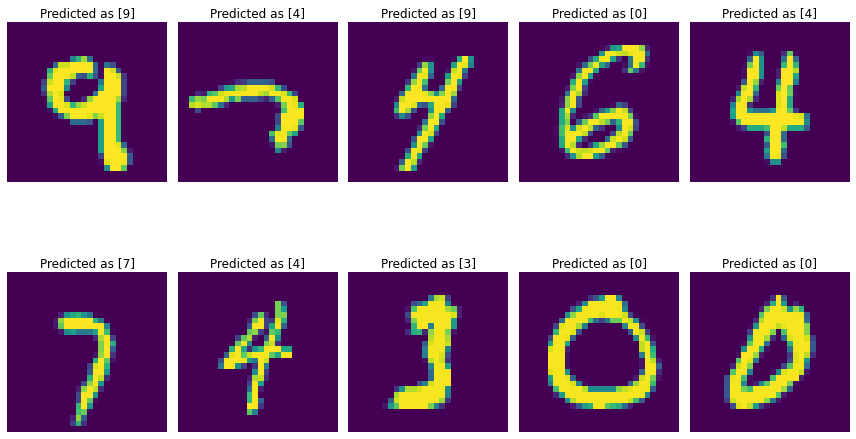

In [15]:
y_pred = bestmodel.predict(X_test)
print(f"The accuracy score of the best model is {accuracy_score(y_test, y_pred)}\n")

plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    sample = random.choice(X_test)
    plt.imshow(sample.reshape(28, 28))
    pred = bestmodel.predict(sample.reshape(1, -1))
    plt.title(f"Predicted as {pred}")
    plt.axis("off")

plt.tight_layout()

In [2]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    accuracy_score,
)
from sklearn.ensemble import RandomForestClassifier

In [4]:
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin",
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('./diabetes.csv', names=names, header=0)

In [5]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


times_pregnant  glucose_tolerance_test  blood_pressure  skin_thickness  \
463               5                      88              78              30   
514               3                      99              54              19   
57                0                     100              88              60   
445               0                     180              78              63   
700               2                     122              76              27   

     insulin   bmi  pedigree_function  age  has_diabetes  
463        0  27.6              0.258   37             0  
514       86  25.6              0.154   24             0  
57       110  46.8              0.962   31             0  
445       14  59.4              2.420   25             1  
700      200  35.9              0.483   26             0

In [7]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [9]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=11111
)

Below, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.

In [10]:
np.mean(y), np.mean(1 - y)

(0.3489583333333333, 0.6510416666666666)

## Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [12]:
# BEGIN SOLUTION
# Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [14]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_rf)))
print('roc-auc for not having diabetes is {:.3f}'.format(
    roc_auc_score(y_test, y_pred_prob_rf[:, 1])))

accuracy is 0.771
roc-auc for not having diabetes is 0.826


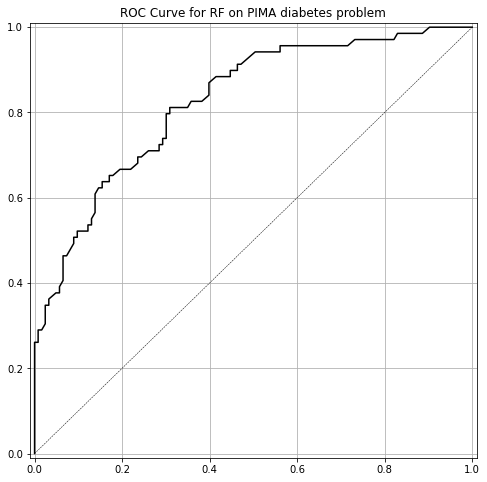

In [15]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')
# END SOLUTION

In [21]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model_1 = Sequential(
    [
        tf.keras.Input(shape=(8,)),
        Dense(12, activation="sigmoid", name="layer1"),
        Dense(1, activation="sigmoid", name="layer2"),
    ]
)

In [22]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 12)                108       
_________________________________________________________________
layer2 (Dense)               (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [23]:
# First let's normalize the data
# This aids the training of neural nets by providing numerical stability
# Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

* The model.compile statement defines a loss function and specifies a compile optimization.
* The model.fit statement runs gradient descent and fits the weights to the data. eg:\
```python
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,
    Yt,
    epochs=10,
)
```

In [24]:
model_1.compile(SGD(lr=.003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train,
                         validation_data=(X_test_norm, y_test), epochs=200)

Train on 576 samples, validate on 192 samples
Epoch 1/200
576/576 [==============================] - 6s 11ms/sample - loss: 0.6184 - accuracy: 0.6632 - val_loss: 0.6260 - val_accuracy: 0.6458
Epoch 2/200
576/576 [==============================] - 0s 746us/sample - loss: 0.6174 - accuracy: 0.6632 - val_loss: 0.6252 - val_accuracy: 0.6458
Epoch 3/200
576/576 [==============================] - 0s 613us/sample - loss: 0.6165 - accuracy: 0.6615 - val_loss: 0.6244 - val_accuracy: 0.6458
Epoch 4/200
576/576 [==============================] - 0s 679us/sample - loss: 0.6156 - accuracy: 0.6597 - val_loss: 0.6236 - val_accuracy: 0.6458
Epoch 5/200
576/576 [==============================] - 0s 814us/sample - loss: 0.6148 - accuracy: 0.6597 - val_loss: 0.6229 - val_accuracy: 0.6458
Epoch 6/200
576/576 [==============================] - 0s 613us/sample - loss: 0.6139 - accuracy: 0.6562 - val_loss: 0.6222 - val_accuracy: 0.6458
Epoch 7/200
576/576 [==============================] - 0s 797us/sample - 

In [25]:
# Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [26]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]], dtype=int32)

In [28]:
y_pred_prob_nn_1[:10]

array([[0.39052612],
       [0.5309594 ],
       [0.35402727],
       [0.3159058 ],
       [0.27830696],
       [0.46871477],
       [0.20337746],
       [0.33310395],
       [0.6048631 ],
       [0.31892222]], dtype=float32)

accuracy is 0.766
roc-auc is 0.816


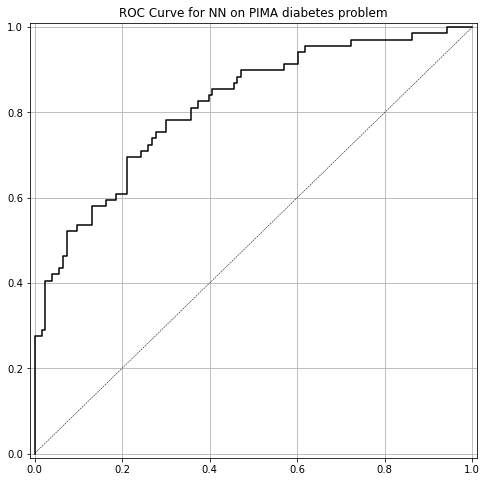

In [29]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

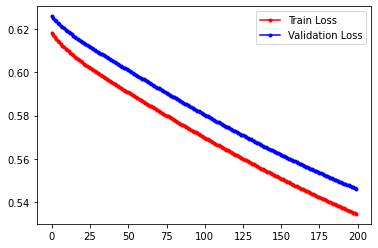

In [30]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"], 'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"], 'b',
        marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.


In [31]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
# Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(
    X_test_norm, y_test), epochs=1000)

Train on 576 samples, validate on 192 samples
Epoch 1/1000
576/576 [==============================] - 0s 409us/sample - loss: 0.5341 - accuracy: 0.7431 - val_loss: 0.5458 - val_accuracy: 0.7656
Epoch 2/1000
576/576 [==============================] - 0s 487us/sample - loss: 0.5338 - accuracy: 0.7431 - val_loss: 0.5455 - val_accuracy: 0.7656
Epoch 3/1000
576/576 [==============================] - 0s 419us/sample - loss: 0.5335 - accuracy: 0.7431 - val_loss: 0.5453 - val_accuracy: 0.7656
Epoch 4/1000
576/576 [==============================] - 0s 527us/sample - loss: 0.5332 - accuracy: 0.7431 - val_loss: 0.5450 - val_accuracy: 0.7656
Epoch 5/1000
576/576 [==============================] - 0s 459us/sample - loss: 0.5329 - accuracy: 0.7431 - val_loss: 0.5447 - val_accuracy: 0.7656
Epoch 6/1000
576/576 [==============================] - 0s 370us/sample - loss: 0.5326 - accuracy: 0.7431 - val_loss: 0.5444 - val_accuracy: 0.7656
Epoch 7/1000
576/576 [==============================] - 0s 512us/s

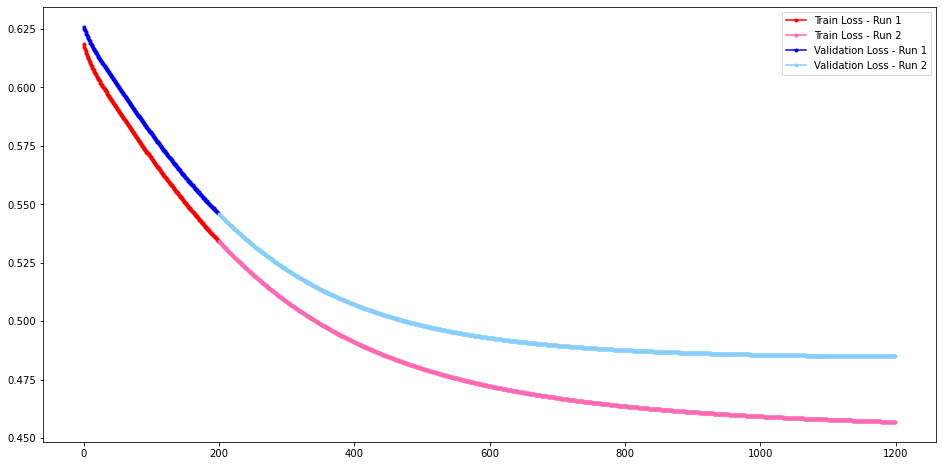

In [33]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],
        'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"],
        'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],
        'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"],
        'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

In [34]:
model_2 = Sequential()
model_2.add(Dense(6, input_shape=(8,), activation="relu"))
model_2.add(Dense(6,  activation="relu"))
model_2.add(Dense(1, activation="sigmoid"))

model_2.compile(SGD(lr=.003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(
    X_test_norm, y_test), epochs=1500)

Train on 576 samples, validate on 192 samples
Epoch 1/1500
576/576 [==============================] - 4s 6ms/sample - loss: 0.6813 - accuracy: 0.6858 - val_loss: 0.6770 - val_accuracy: 0.6667
Epoch 2/1500
576/576 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.70 - 0s 673us/sample - loss: 0.6782 - accuracy: 0.6927 - val_loss: 0.6742 - val_accuracy: 0.6667
Epoch 3/1500
576/576 [==============================] - 0s 618us/sample - loss: 0.6752 - accuracy: 0.6910 - val_loss: 0.6715 - val_accuracy: 0.6667
Epoch 4/1500
576/576 [==============================] - 0s 591us/sample - loss: 0.6722 - accuracy: 0.6944 - val_loss: 0.6689 - val_accuracy: 0.6667
Epoch 5/1500
576/576 [==============================] - 0s 519us/sample - loss: 0.6694 - accuracy: 0.6944 - val_loss: 0.6663 - val_accuracy: 0.6667
Epoch 6/1500
576/576 [==============================] - 0s 752us/sample - loss: 0.6666 - accuracy: 0.6944 - val_loss: 0.6638 - val_accuracy: 0.6615
Epoch 7/1500
576/576 [====

In [36]:
run_hist_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy over iterations')

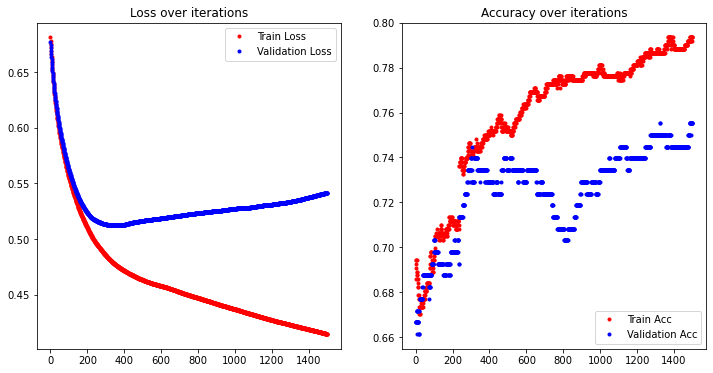

In [37]:
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_2.history["loss"]), "r.", label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]), "b.", label="Validation Loss")
ax.legend()
ax.set_title("Loss over iterations")

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_2.history["accuracy"]), "r.", label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_accuracy"]), "b.", label="Validation Acc")
ax.legend(loc="lower right")
ax.set_title("Accuracy over iterations")


accuracy is 0.755
roc-auc is 0.806


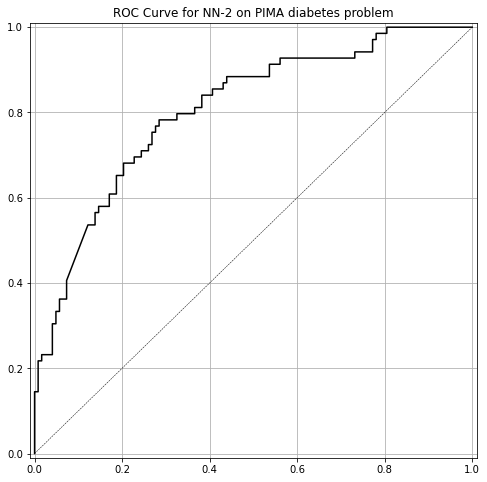

In [38]:
y_pred_class_nn_2 = model_2.predict_classes(X_test_norm)
y_pred_prob_nn_2 = model_2.predict(X_test_norm)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')

## Linear Regression
### Goal: 

Try to understand the factors on which the demand for shared bikes depends. Perform a linear regression to predict the count of total rental bikes, and understand the impact of some contributing factors.

### Bike sharing dataset

We will be using the bike-sharing dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01). It contains the following features:

> - instant: record index
> - dteday : date
> - season : season (1:winter, 2:spring, 3:summer, 4:fall)
> - yr : year (0: 2011, 1:2012)
> - mnth : month ( 1 to 12)
> - hr : hour (0 to 23)
> - holiday : weather day is holiday or not (extracted from [Web Link](https://dchr.dc.gov/page/holiday-schedules?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01))
> - weekday : day of the week
> - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
> - weathersit :(1) Clear, Few clouds, Partly cloudy, Partly cloudy, (2) Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist, (3) Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds, (4) Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
> - temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 
> - atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
> hum: Normalized humidity. The values are divided to 100 (max)
> windspeed: Normalized wind speed. The values are divided to 67 (max)
> casual: count of casual users
> registered: count of registered users
> cnt: count of total rental bikes including both casual and registered


In [3]:
raw_dataset = pd.read_csv("day.csv")

In [4]:
raw_dataset.sample(5)

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
438      439  2012-03-14       1   1     3        0        3           1   
8          9  2011-01-09       1   0     1        0        0           0   
325      326  2011-11-22       4   0    11        0        2           1   
10        11  2011-01-11       1   0     1        0        2           1   
434      435  2012-03-10       1   1     3        0        6           0   

     weathersit      temp     atemp       hum  windspeed  casual  registered  \
438           1  0.572500  0.548617  0.507083   0.115062     997        5315   
8             1  0.138333  0.116175  0.434167   0.361950      54         768   
325           3  0.416667  0.421696  0.962500   0.118792      69        1538   
10            2  0.169091  0.191464  0.686364   0.122132      43        1220   
434           1  0.287500  0.277767  0.350417   0.225750     968        3150   

      cnt  
438  6312  
8     822  
325  1607  
10   1263  
434  4118

### Clean the data 

Let us drop the `dteday` column as it is not numerical, and we already have some other date like features like `mnth`, `year` and `weekday`.

We will remove `instant` as it is just a row instance identifier.

We will also drop `registered` and `casual` as they are used to compute our target variable `cnt` and including them would result in data leakage.


In [5]:
raw_dataset = raw_dataset.drop(columns=["dteday", "instant", "registered", "casual"])

## Bivariate analysis on numeric data

there is a positive correlation between `temp` and `atemp` and `cnt`. There is a negative correlation between `windspeed` and `hum` and `cnt`

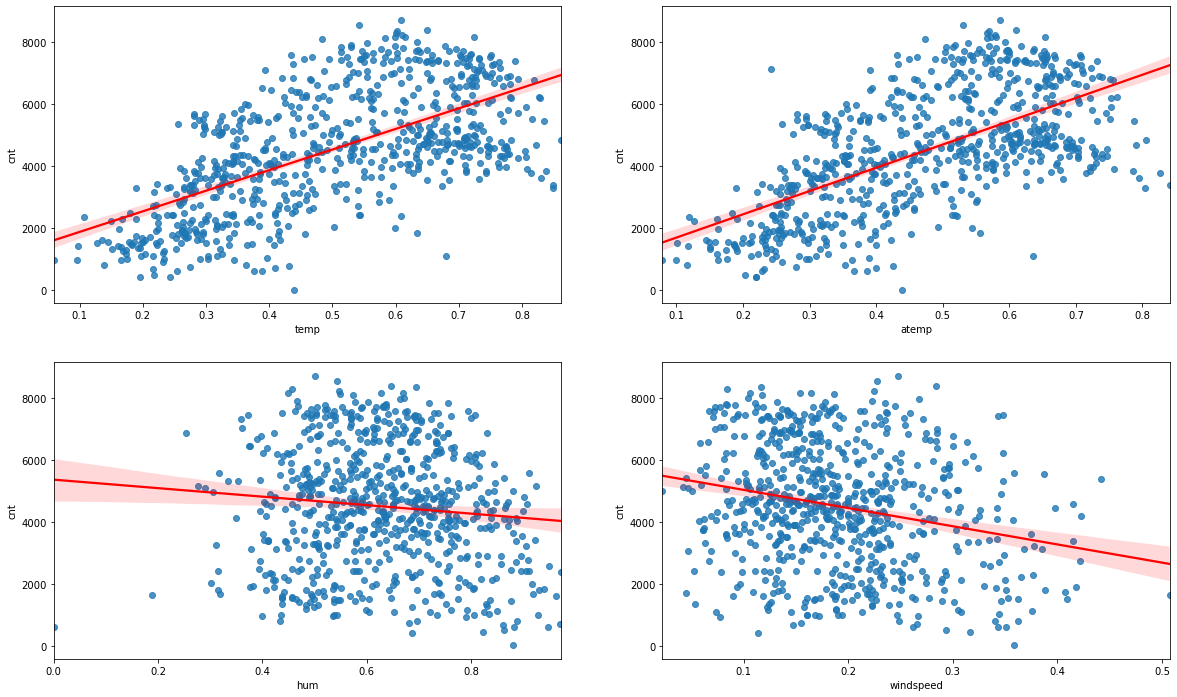

In [42]:
col = ['temp', 'atemp', 'hum', 'windspeed']
plt.figure(figsize=[20, 12])
for i in enumerate(col):
    plt.subplot(2, 2, i[0]+1)
    sns.regplot(data=raw_dataset, x=i[1], y='cnt', line_kws={"color": 'red'})

plt.show()

## Bivariate analysis on categorical data

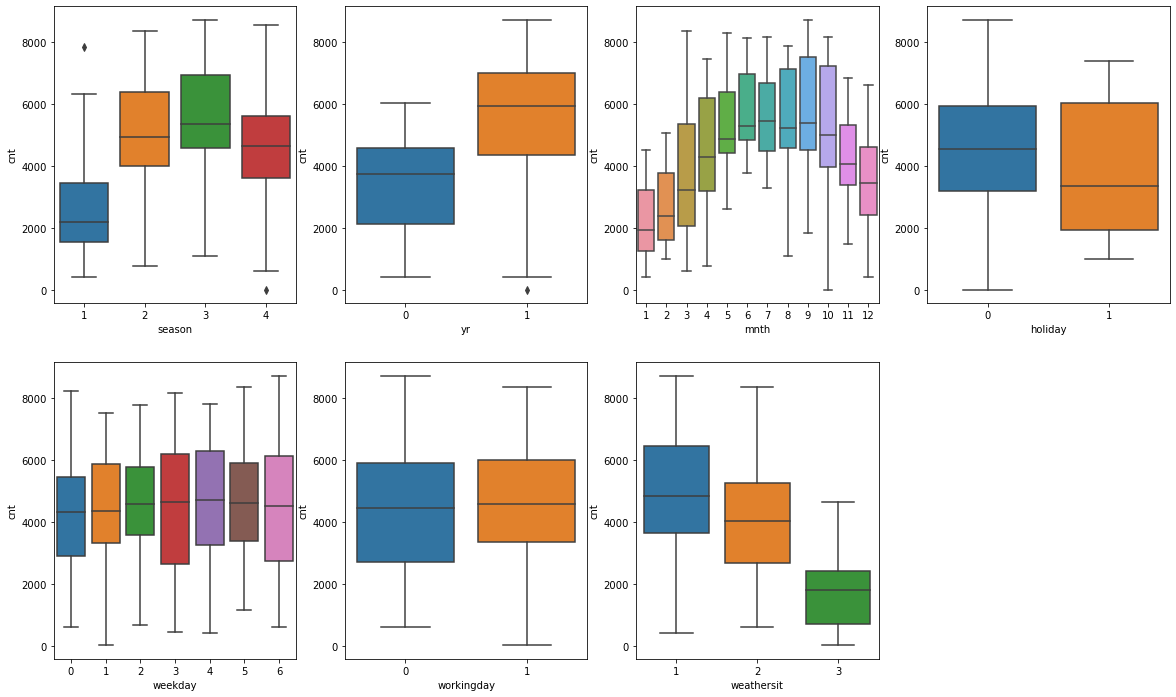

In [43]:
col = ['season', 'yr', 'mnth', 'holiday',
       'weekday', 'workingday', 'weathersit']
plt.figure(figsize=[20, 12])
for i in enumerate(col):
    plt.subplot(2, 4, i[0]+1)
    sns.boxplot(data=raw_dataset, x=i[1], y='cnt')

plt.show()

## Multivariate analysis

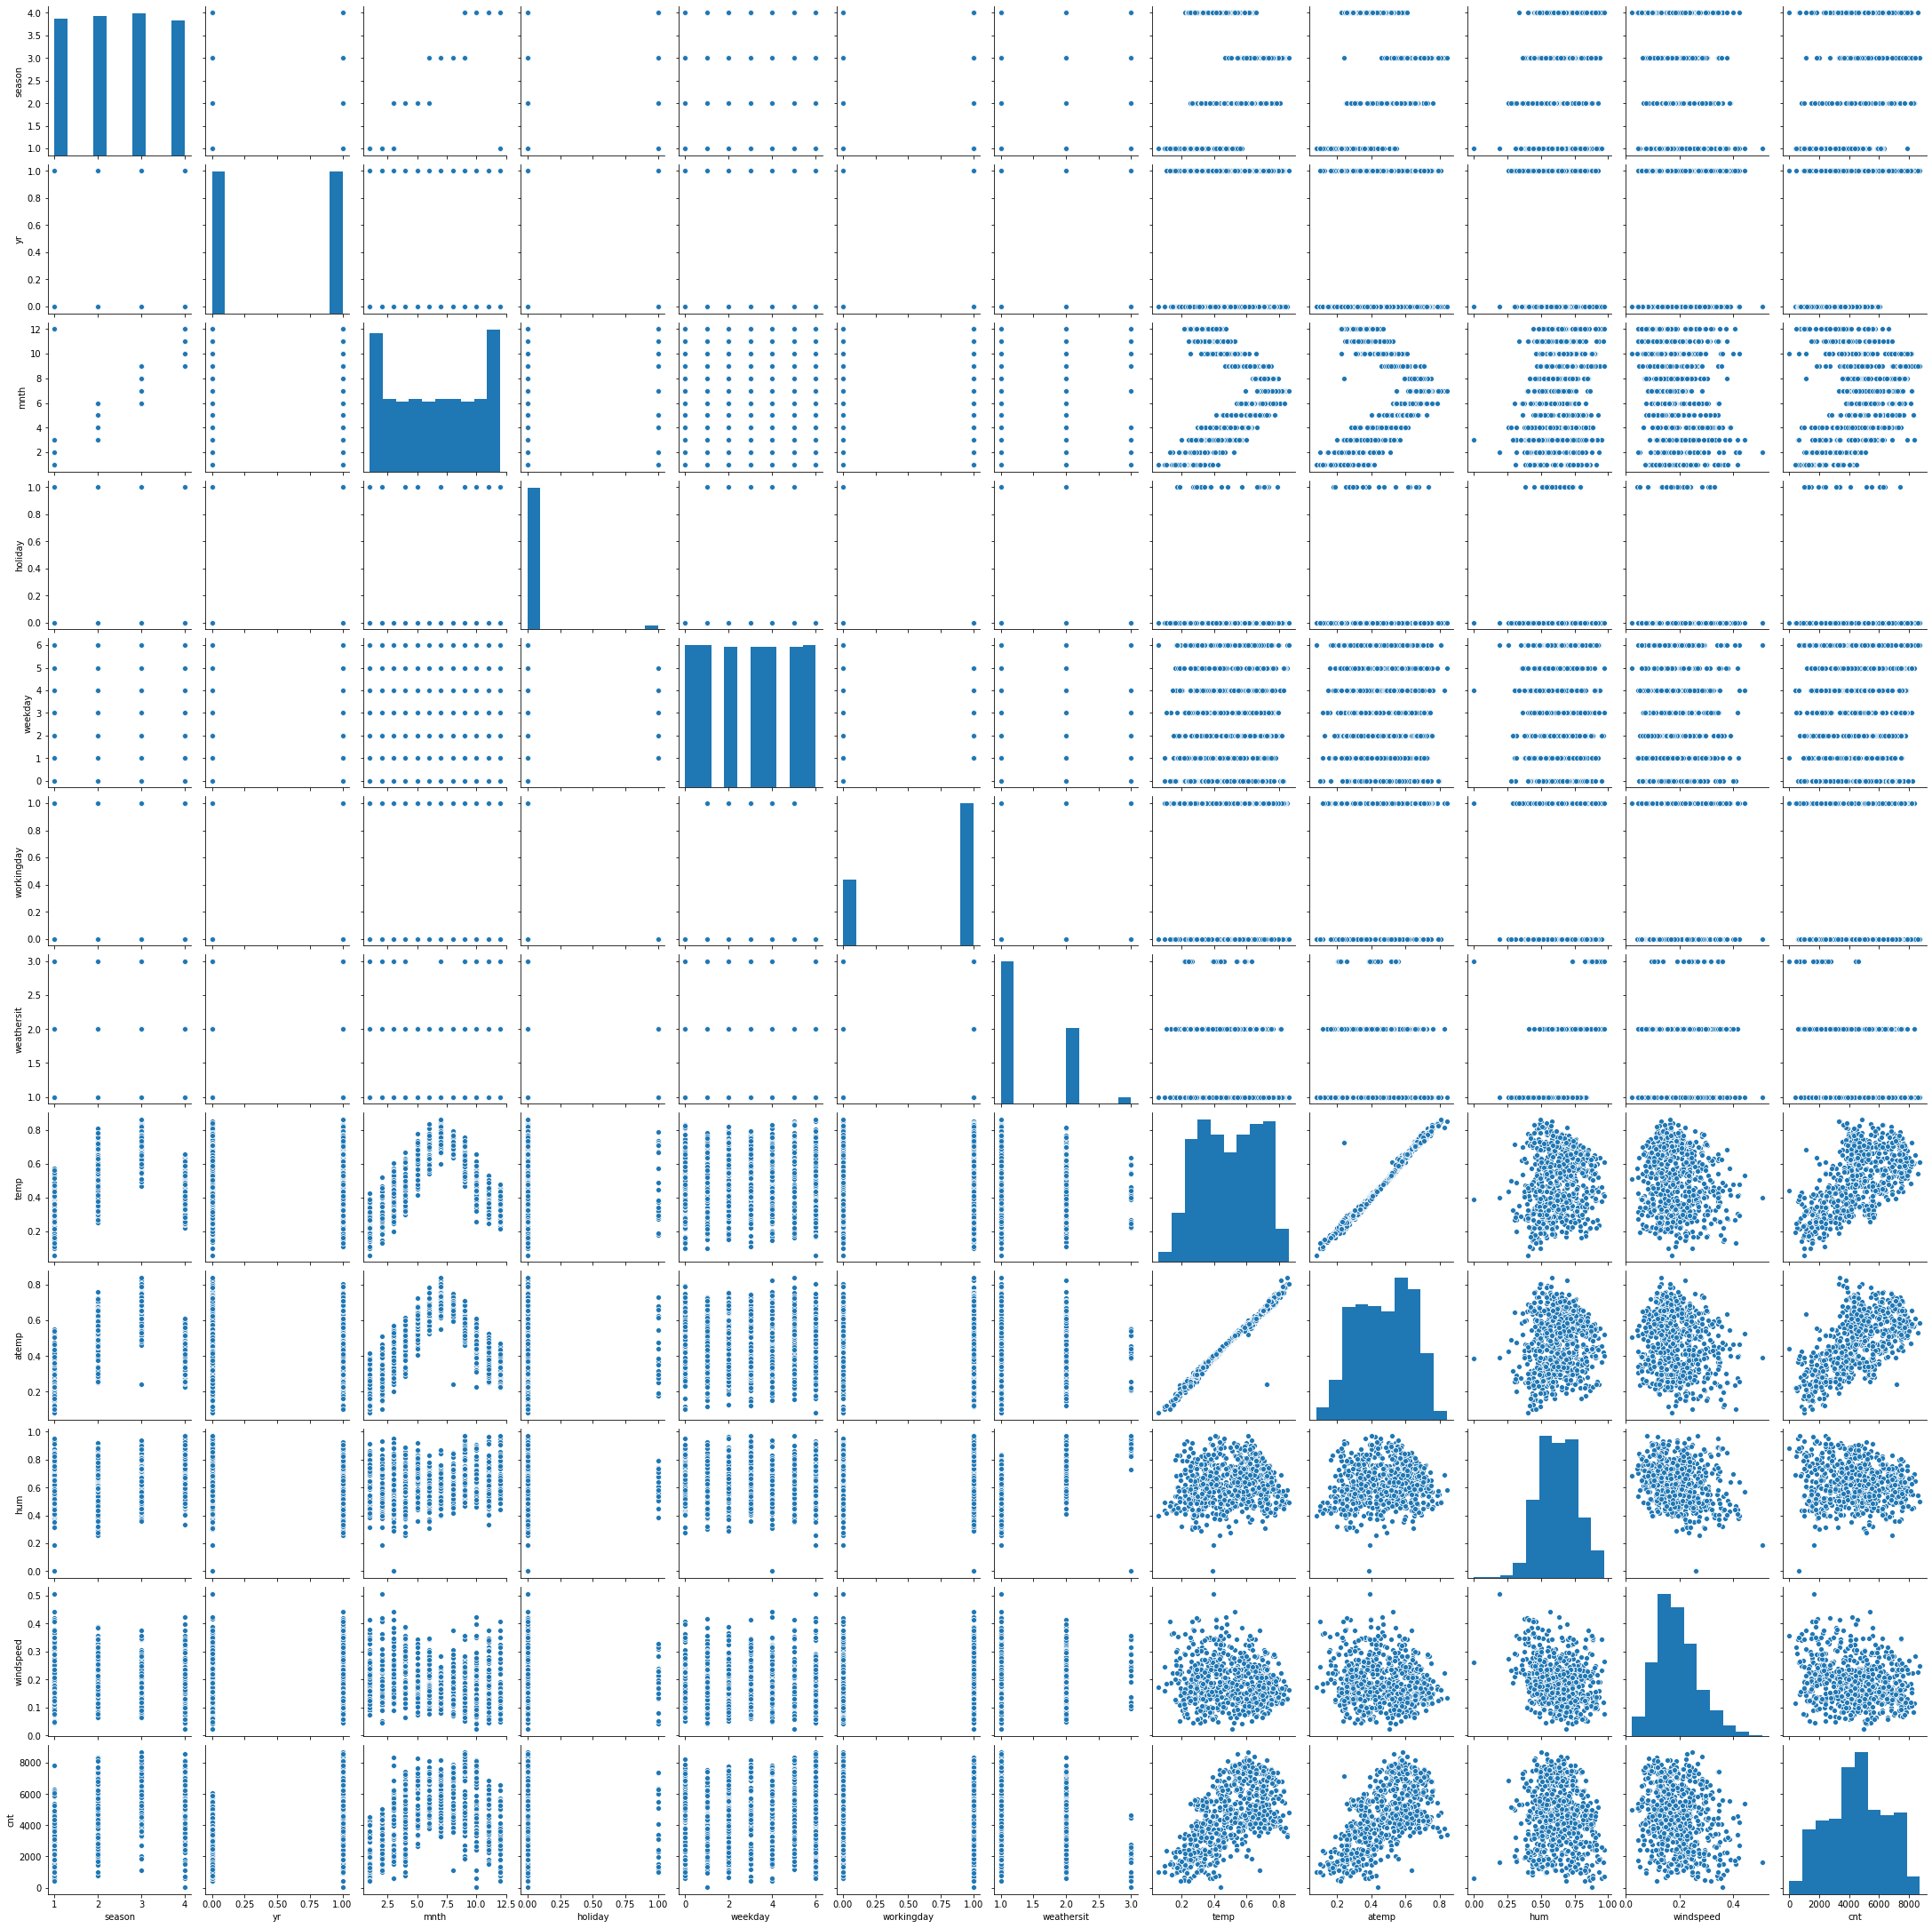

In [44]:
sns.pairplot(raw_dataset)

## Heatmap of columns

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 <a list of 12 Text major ticklabel objects>)

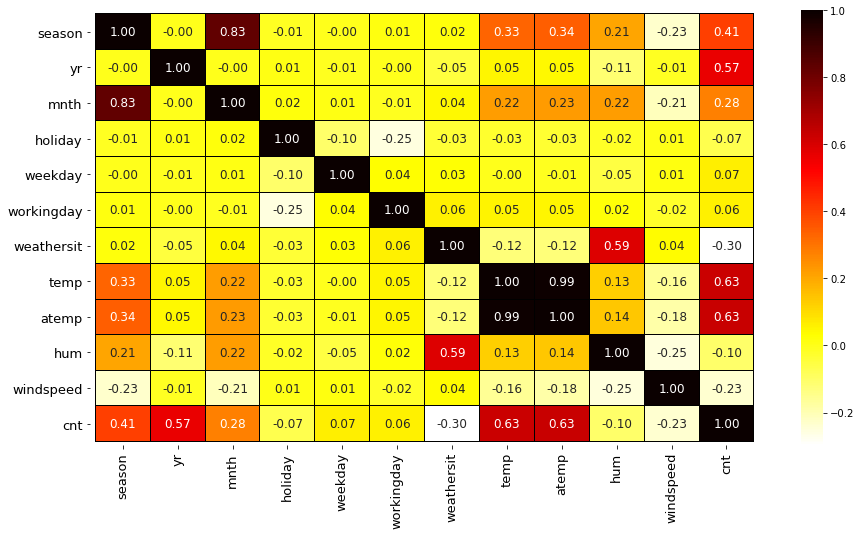

In [45]:
plt.figure(figsize=[15, 8])
fig = sns.heatmap(raw_dataset.corr(), cmap='hot_r',
                  annot=True, linecolor='black', linewidths=0.01, annot_kws={"fontsize": 12}, fmt="0.2f")

top, bottom = fig.get_ylim()
fig.set_ylim(top+0.1, bottom-0.1)

left, right = fig.get_xlim()
fig.set_xlim(left-0.1, right+0.1)

plt.yticks(fontsize=13, rotation=0)
plt.xticks(fontsize=13, rotation=90)

From the heatmap, we can infer that `temp` and `atemp` are highly correlated with each other and with `cnt`.

A positive correlation between `temp`, `atemp`, `yr` and `cnt` exists, while a negative correlation between `windspeed`, `hum`, `weathersit`, `holiday` and `cnt` exists.


In [46]:
train_dataset = raw_dataset.sample(frac=0.8, random_state=0)
test_dataset = raw_dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("cnt")
test_labels = test_features.pop("cnt")

In [6]:
X = raw_dataset.drop(columns=["cnt"])  # .values
y = raw_dataset["cnt"]  # .values
X.shape, y.shape, X.head()

((731, 11),
 (731,),
    season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
 0       1   0     1        0        6           0           2  0.344167   
 1       1   0     1        0        0           0           2  0.363478   
 2       1   0     1        0        1           1           1  0.196364   
 3       1   0     1        0        2           1           1  0.200000   
 4       1   0     1        0        3           1           1  0.226957   
 
       atemp       hum  windspeed  
 0  0.363625  0.805833   0.160446  
 1  0.353739  0.696087   0.248539  
 2  0.189405  0.437273   0.248309  
 3  0.212122  0.590435   0.160296  
 4  0.229270  0.436957   0.186900  )

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11111
)

### Linear Regression with single input

In [8]:
temp = X_train["temp"]

layer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
layer.adapt(temp)

In [9]:
temp_model = Sequential([layer, Dense(units=1)])
temp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [10]:
temp_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss="mean_squared_error"
)

In [11]:
%%time
history = temp_model.fit(
    X_train['temp'],
    y_train,
    # to view the logs, uncomment this:
    verbose=False,
    epochs=100,
    # validation split: 20% of the training data.
    validation_split = 0.2)

CPU times: user 22.8 s, sys: 1.64 s, total: 24.4 s
Wall time: 43.3 s


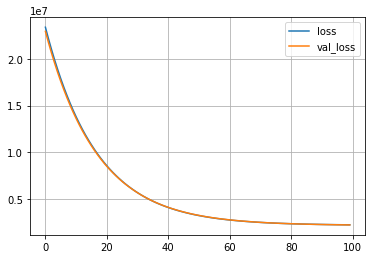

In [12]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.grid(True)


plot_loss(history)

In [13]:
y_pred = temp_model.predict(X_test['temp'])

In [17]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(y_test, y_pred)))

1599.4376222261733


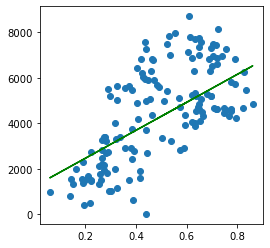

In [19]:
plt.figure(figsize=(4, 4))
plt.plot(
    X_test["temp"], y_test, "o", X_test["temp"], temp_model.predict(X_test["temp"]), "g"
)
plt.show()

### Linear Regression with Multiple inputs

In [20]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)

linear_model = Sequential([normalizer, Dense(units=1)])

linear_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss="mean_squared_error"
)

In [22]:
%%time
history = linear_model.fit(
    X_train,
    y_train,
    epochs=100,
    # to view the logs, uncomment this:
    verbose=0,
    # validation split: 20% of the training data.
    validation_split = 0.2)

CPU times: user 23.4 s, sys: 1.78 s, total: 25.2 s
Wall time: 43.2 s


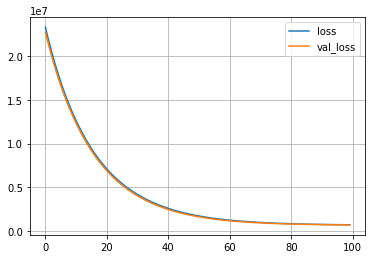

In [23]:
plot_loss(history)

In [25]:
y_pred = linear_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

1040.1006543100316


### Using Complex Neural Network

In [28]:
output_size = 1
hidden_layer = 500
input_size = 1
learning_rate = 0.51
loss_function = "mean_squared_error"
epochs = 30
batch_size = 10

model = Sequential(normalizer)
model.add(Dense(hidden_layer, activation="relu"))

model.add(Dense(output_size))

In [29]:
model.compile(tf.keras.optimizers.Adam(lr=learning_rate), loss_function)

In [31]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/30
59/59 [==============================] - 3s 10ms/step - loss: 3731475.2500
Epoch 2/30
59/59 [==============================] - 1s 12ms/step - loss: 1283616.0000
Epoch 3/30
59/59 [==============================] - 1s 11ms/step - loss: 1190526.3750
Epoch 4/30
59/59 [==============================] - 1s 11ms/step - loss: 1311024.2500
Epoch 5/30
59/59 [==============================] - 1s 13ms/step - loss: 1217935.7500
Epoch 6/30
59/59 [==============================] - 1s 11ms/step - loss: 688165.6875
Epoch 7/30
59/59 [==============================] - 1s 11ms/step - loss: 1063195.3750
Epoch 8/30
59/59 [==============================] - 1s 9ms/step - loss: 1064137.7500
Epoch 9/30
59/59 [==============================] - 1s 10ms/step - loss: 732163.9375
Epoch 10/30
59/59 [==============================] - 1s 9ms/step - loss: 496926.6250
Epoch 11/30
59/59 [==============================] - 1s 11ms/step - loss: 461430.0938
Epoch 12/30
59/59 [==============================] - 1s 10

In [32]:
y_pred = model.predict(X_test)

In [40]:
print(np.sqrt(mean_squared_error(y_test, y_pred)))

791.6071819831315


### Working with backpropagation 

shape of x_mat_full is (500, 3)
shape of y is (500,)


(-1.0947171639904798,
 1.0963214635346772,
 -1.099492408355376,
 1.0996064791561153)

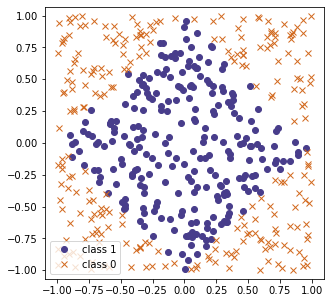

In [41]:
num_obs = 500
x_mat_1 = np.random.uniform(-1, 1, size=(num_obs, 2))
x_mat_bias = np.ones((num_obs, 1))
x_mat_full = np.concatenate((x_mat_1, x_mat_bias), axis=1)

y = ((np.abs(x_mat_full[:, 0]) + np.abs(x_mat_full[:, 1])) < 1).astype(int)

print('shape of x_mat_full is {}'.format(x_mat_full.shape))
print('shape of y is {}'.format(y.shape))

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_mat_full[y == 1, 0], x_mat_full[y == 1, 1],
        'ro', label='class 1', color='darkslateblue')
ax.plot(x_mat_full[y == 0, 0], x_mat_full[y == 0, 1],
        'bx', label='class 0', color='chocolate')
# ax.grid(True)
ax.legend(loc='best')
ax.axis('equal')

In [42]:
def sigmoid(x):
    """
    Sigmoid function
    """
    return 1.0 / (1.0 + np.exp(-x))


def loss_fn(y_true, y_pred, eps=1e-16):
    """
    Loss function we would like to optimize (minimize)
    We are using Logarithmic Loss
    http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss
    """
    y_pred = np.maximum(y_pred, eps)
    y_pred = np.minimum(y_pred, (1-eps))
    return -(np.sum(y_true * np.log(y_pred)) + np.sum((1-y_true)*np.log(1-y_pred)))/len(y_true)


def forward_pass(W1, W2):
    """
    Does a forward computation of the neural network
    Takes the input `x_mat` (global variable) and produces the output `y_pred`
    Also produces the gradient of the log loss function
    """
    global x_mat
    global y
    global num_
    # First, compute the new predictions `y_pred`
    z_2 = np.dot(x_mat, W1)
    a_2 = sigmoid(z_2)
    z_3 = np.dot(a_2, W2)
    y_pred = sigmoid(z_3).reshape((len(x_mat),))
    # Now compute the gradient
    J_z_3_grad = -y + y_pred
    J_W_2_grad = np.dot(J_z_3_grad, a_2)
    a_2_z_2_grad = sigmoid(z_2)*(1-sigmoid(z_2))
    J_W_1_grad = (np.dot((J_z_3_grad).reshape(-1, 1),
                  W_2.reshape(-1, 1).T)*a_2_z_2_grad).T.dot(x_mat).T
    gradient = (J_W_1_grad, J_W_2_grad)

    # return
    return y_pred, gradient


def plot_loss_accuracy(loss_vals, accuracies):
    fig = plt.figure(figsize=(16, 8))
    fig.suptitle('Log Loss and Accuracy over iterations')

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(loss_vals)
    ax.grid(True)
    ax.set(xlabel='iterations', title='Log Loss')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(accuracies)
    ax.grid(True)
    ax.set(xlabel='iterations', title='Accuracy')

iteration 0, log loss is 0.8161, accuracy is 0.494
iteration 200, log loss is 0.6860, accuracy is 0.602
iteration 400, log loss is 0.6686, accuracy is 0.654
iteration 600, log loss is 0.6070, accuracy is 0.756
iteration 800, log loss is 0.5404, accuracy is 0.76
iteration 1000, log loss is 0.5162, accuracy is 0.756
iteration 1200, log loss is 0.4997, accuracy is 0.76
iteration 1400, log loss is 0.4480, accuracy is 0.798
iteration 1600, log loss is 0.3784, accuracy is 0.864
iteration 1800, log loss is 0.3314, accuracy is 0.878
iteration 2000, log loss is 0.2989, accuracy is 0.902
iteration 2200, log loss is 0.2695, accuracy is 0.908
iteration 2400, log loss is 0.2437, accuracy is 0.93
iteration 2600, log loss is 0.2234, accuracy is 0.946
iteration 2800, log loss is 0.2082, accuracy is 0.95
iteration 3000, log loss is 0.1966, accuracy is 0.958
iteration 3200, log loss is 0.1875, accuracy is 0.96
iteration 3400, log loss is 0.1800, accuracy is 0.968
iteration 3600, log loss is 0.1736, accu

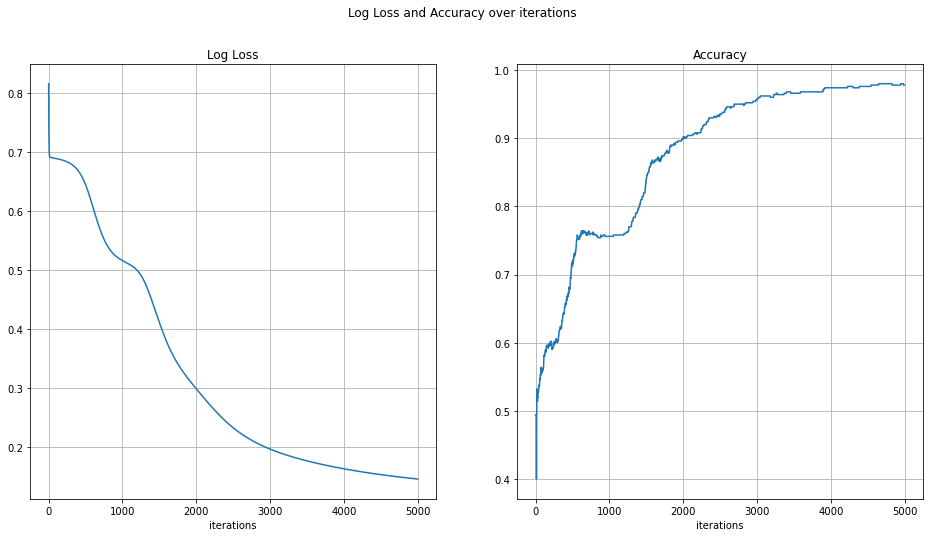

In [43]:
# Initialize the network parameters

np.random.seed(1241)

W_1 = np.random.uniform(-1, 1, size=(3, 4))
W_2 = np.random.uniform(-1, 1, size=(4))
num_iter = 5000
learning_rate = .001
x_mat = x_mat_full


loss_vals, accuracies = [], []
for i in range(num_iter):
    # Do a forward computation, and get the gradient
    y_pred, (J_W_1_grad, J_W_2_grad) = forward_pass(W_1, W_2)

    # Update the weight matrices
    W_1 = W_1 - learning_rate*J_W_1_grad
    W_2 = W_2 - learning_rate*J_W_2_grad

    # Compute the loss and accuracy
    curr_loss = loss_fn(y, y_pred)
    loss_vals.append(curr_loss)
    acc = np.sum((y_pred >= .5) == y)/num_obs
    accuracies.append(acc)

    # Print the loss and accuracy for every 200th iteration
    if ((i % 200) == 0):
        print('iteration {}, log loss is {:.4f}, accuracy is {}'.format(
            i, curr_loss, acc
        ))
plot_loss_accuracy(loss_vals, accuracies)

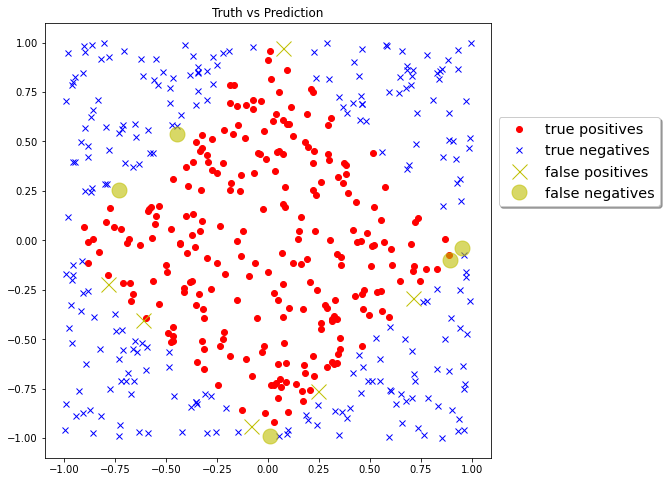

In [44]:
pred1 = (y_pred >= .5)
pred0 = (y_pred < .5)

fig, ax = plt.subplots(figsize=(8, 8))
# true predictions
ax.plot(x_mat[pred1 & (y == 1), 0], x_mat[pred1 &
        (y == 1), 1], 'ro', label='true positives')
ax.plot(x_mat[pred0 & (y == 0), 0], x_mat[pred0 &
        (y == 0), 1], 'bx', label='true negatives')
# false predictions
ax.plot(x_mat[pred1 & (y == 0), 0], x_mat[pred1 & (y == 0), 1],
        'yx', label='false positives', markersize=15)
ax.plot(x_mat[pred0 & (y == 1), 0], x_mat[pred0 & (y == 1), 1],
        'yo', label='false negatives', markersize=15, alpha=.6)
ax.set(title='Truth vs Prediction')
ax.legend(bbox_to_anchor=(1, 0.8), fancybox=True,
          shadow=True, fontsize='x-large')

## Optimizers - application to a classification problem

In [46]:
food_df = pd.read_csv("food.csv")

In [47]:
food_df.shape

(13260, 19)

In [49]:
food_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13260 entries, 0 to 13259
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           13260 non-null  int64  
 1   Calories             13260 non-null  float64
 2   Total Fat            13260 non-null  int64  
 3   Saturated Fat        13260 non-null  float64
 4   Monounsaturated Fat  13260 non-null  float64
 5   Polyunsaturated Fat  13260 non-null  float64
 6   Trans Fat            13260 non-null  float64
 7   Cholesterol          13260 non-null  int64  
 8   Sodium               13260 non-null  float64
 9   Total Carbohydrate   13260 non-null  float64
 10  Dietary Fiber        13260 non-null  float64
 11  Sugars               13260 non-null  float64
 12  Sugar Alcohol        13260 non-null  int64  
 13  Protein              13260 non-null  float64
 14  Vitamin A            13260 non-null  int64  
 15  Vitamin C            13260 non-null 

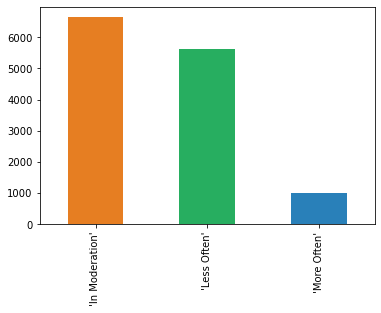

In [51]:
food_df.iloc[:, -1].value_counts().plot.bar(color=['#e67e22',
                                                   '#27ae60', '#2980b9'])

In [79]:
X_raw = food_df.iloc[:, :-1]
y_raw = food_df.iloc[:, -1:]

In [80]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()
# Scaling the raw input features
X = scaler.fit_transform(X_raw)

In [57]:
y_raw.values.ravel()

array(["'In Moderation'", "'In Moderation'", "'In Moderation'", ...,
       "'In Moderation'", "'In Moderation'", "'In Moderation'"],
      dtype=object)

In [81]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw.values.ravel())

In [62]:
y.max(), y.min()

(2, 0)

In [82]:
# First, let's split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)
print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Training dataset shape, X_train: (10608, 18), y_train: (10608,)
Testing dataset shape, X_test: (2652, 18), y_test: (2652,)


In [65]:
base_ann = MLPClassifier(
    random_state=123,
    hidden_layer_sizes=(32, 8),
    solver="sgd",
    momentum=0,
    early_stopping=True,
    max_iter=100,
)

In [68]:
import time


def fit_and_score(model, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start
    n_iter = model.n_iter_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    loss_curve = model.loss_curve_
    return round(fit_time, 2), n_iter, train_score, test_score


fit_time, n_iter, train_score, test_score = fit_and_score(
    base_ann, X_train, X_test, y_train, y_test)

In [69]:
print(
    f"Training converged after {n_iter} iterations with train score (accuracy) {round(train_score, 2)} \
and test score (accuracy) {round(test_score, 2)}."
)

Training converged after 12 iterations with train score (accuracy) 0.42 and test score (accuracy) 0.42.


As we can see from above cell output, a classification task with accuracy around `40%` is definitly unacceptable. But how is it even possible as we are using a Neural Network to do the task!

Such bad train and test score is normally considered as underfitting which actually happends very often in training neural networks which is normally more complex than shallow models. The reasons could be too simple network architecture, insufficient training data or iterations, trapped in local minima, etc.

For our case, it could be the bad quality or low predictability of our dataset. To verify that, let's try to build a simple logistic regression to see if it can perform the task well.



In [72]:
from sklearn.linear_model import LogisticRegression

# Define a logistic regression model with above arguments
lr_model = LogisticRegression(random_state=123, max_iter=200)
lr_model.fit(X_train, y_train)
lr_score = lr_model.score(X_test, y_test)
print(f"The test score for the logistic regression is {round(lr_score, 2)}")

The test score for the logistic regression is 0.77


## Retrain the Neural Network with momentum


In [73]:
momentum_ann = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8),
                             solver='sgd', momentum=0.9,
                             early_stopping=True,
                             max_iter=100)
fit_time, n_iter, train_score, test_score = fit_and_score(
    momentum_ann, X_train, X_test, y_train, y_test)
print(
    f"Training converged after {n_iter} iterations with test score (accuracy) {round(test_score, 2)}")

Training converged after 100 iterations with test score (accuracy) 0.73


### Retrain the Neural Network with Nesterov’s momentum


In [74]:
nesterovs_ann = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8),
                              solver='sgd', momentum=0.95,
                              nesterovs_momentum=True,
                              early_stopping=True,
                              max_iter=100)
fit_time, n_iter, train_score, test_score = fit_and_score(
    nesterovs_ann, X_train, X_test, y_train, y_test)
print(
    f"Training converged after {n_iter} iterations with score (accuracy) {round(test_score, 2)}")

Training converged after 67 iterations with score (accuracy) 0.73


### Retrain the Neural Network with Adam


In [75]:
adam_ann = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8),
                         solver='adam',
                         early_stopping=True,
                         max_iter=100)
fit_time, n_iter, train_score, test_score = fit_and_score(
    adam_ann, X_train, X_test, y_train, y_test)
print(
    f"Training converged after {n_iter} iterations with score (accuracy) {round(test_score, 2)}")

Training converged after 70 iterations with score (accuracy) 0.84


In [84]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


# Create Keras Sequential Model as base model
def create_model(neurons=10):
    model = Sequential()
    model.add(Dense(neurons, activation="linear"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(3, activation="softmax"))
    model.compile(
        optimizer="RMSprop", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


np.random.seed(0)
base_model = KerasClassifier(build_fn=create_model, verbose=0, batch_size=10, epochs=1)

# Get pre-tuned results
base_model.fit(X_train, y_train)
base_score = base_model.score(X_test, y_test)
print("The baseline accuracy is: %.3f" % base_score)

The baseline accuracy is: 0.734


## Randomized/Grid Search


In [85]:
batch_size = [10, 20, 60, 80]
epochs = [1, 3, 5]
neurons = [1, 10, 20, 30]

params = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)
params

{'batch_size': [10, 20, 60, 80],
 'epochs': [1, 3, 5],
 'neurons': [1, 10, 20, 30]}

In [86]:
search = RandomizedSearchCV(
    estimator=base_model, param_distributions=params, cv=3)

In [87]:
search_result = search.fit(X_train, y_train)

means = search_result.cv_results_["mean_test_score"]
stds = search_result.cv_results_["std_test_score"]
params = search_result.cv_results_["params"]

In [88]:
print("Best mean cross-validated score: {} using {}".format(
    round(search_result.best_score_, 3), search_result.best_params_))

Best mean cross-validated score: 0.809 using {'neurons': 20, 'epochs': 5, 'batch_size': 10}


In [90]:
print("Best test score: %.3f" % search_result.best_estimator_.score(X_test, y_test))

Best test score: 0.804


In [91]:
for mean, stdev, param in zip(means, stds, params):
    print("Mean cross-validated score: {} ({}) using: {}".format(round(mean,
          3), round(stdev, 3), param))

Mean cross-validated score: 0.742 (0.009) using: {'neurons': 10, 'epochs': 3, 'batch_size': 60}
Mean cross-validated score: 0.732 (0.017) using: {'neurons': 1, 'epochs': 3, 'batch_size': 10}
Mean cross-validated score: 0.72 (0.021) using: {'neurons': 20, 'epochs': 1, 'batch_size': 60}
Mean cross-validated score: 0.743 (0.009) using: {'neurons': 20, 'epochs': 3, 'batch_size': 60}
Mean cross-validated score: 0.705 (0.026) using: {'neurons': 1, 'epochs': 5, 'batch_size': 60}
Mean cross-validated score: 0.681 (0.046) using: {'neurons': 10, 'epochs': 1, 'batch_size': 80}
Mean cross-validated score: 0.779 (0.003) using: {'neurons': 20, 'epochs': 5, 'batch_size': 60}
Mean cross-validated score: 0.601 (0.034) using: {'neurons': 1, 'epochs': 3, 'batch_size': 80}
Mean cross-validated score: 0.8 (0.008) using: {'neurons': 30, 'epochs': 3, 'batch_size': 10}
Mean cross-validated score: 0.809 (0.004) using: {'neurons': 20, 'epochs': 5, 'batch_size': 10}


In [100]:
from tensorflow.keras.layers import Dense, Dropout

# Create Keras Sequential Model as base model


def create_model(optimizer="RMSprop", optimizer__learning_rate=0.1, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(64, activation="linear"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(3, activation="softmax"))
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


np.random.seed(0)
base_model = KerasClassifier(build_fn=create_model, verbose=0, batch_size=100, epochs=1)
base_model.fit(X_train, y_train)
base_score = base_model.score(X_test, y_test)
print("The baseline accuracy is: {}".format(base_score))

The baseline accuracy is: 0.7311462759971619


In [101]:
# base_model = KerasClassifier(build_fn=create_model, verbose=0, batch_size=100, epochs=1)

optimizer = ["SGD", "RMSprop", "Adam"]
learning_rate = [0.01, 0.1, 1]
dropout_rate = [0.1, 0.3, 0.6, 0.9]
params = dict(
    optimizer=optimizer,
    optimizer__learning_rate=learning_rate,
    dropout_rate=dropout_rate,
)

search = RandomizedSearchCV(estimator=base_model, param_distributions=params, cv=3)
search_result = search.fit(X_train, y_train)

In [102]:
print(
    "Best mean cross-validated score: {} using {}".format(
        round(search_result.best_score_, 3), search_result.best_params_
    )
)
print("Best test score: %.3f" % search_result.best_estimator_.score(X_test, y_test))

Best mean cross-validated score: 0.704 using {'optimizer__learning_rate': 0.1, 'optimizer': 'Adam', 'dropout_rate': 0.3}


Best test score: 0.728


### Binary Classification


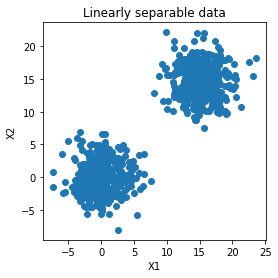

In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.losses import (
    CategoricalCrossentropy,
    SparseCategoricalCrossentropy,
    BinaryCrossentropy,
)
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical


def generate_binary_blobs(num_samples_total, training_split, loss_function_used):
    X, targets = make_blobs(
        n_samples=num_samples_total,
        centers=[(0, 0), (15, 15)],
        n_features=2,
        center_box=(0, 1),
        cluster_std=2.5,
    )
    targets[np.where(targets == 0)] = -1
    X_training = X[training_split:, :]
    X_testing = X[:training_split, :]
    Targets_training = targets[training_split:]
    Targets_testing = targets[:training_split]
    return X_training, Targets_training, X_testing, Targets_testing


num_samples = 1000
test_split = 250
cluster_centers = [(15, 0), (30, 15)]
num_classes = len(cluster_centers)
loss_function_used = BinaryCrossentropy(from_logits=True)

X_training, Targets_training, X_testing, Targets_testing = generate_binary_blobs(
    num_samples, test_split, loss_function_used
)

plt.figure(figsize=(4, 4))
plt.scatter(X_training[:, 0], X_training[:, 1])
plt.title("Linearly separable data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [3]:
X_training.shape, Targets_training.shape, np.unique(Targets_training)

((750, 2), (750,), array([-1,  1]))

In [4]:
feature_vector_shape = X_training.shape[1]
input_shape = (feature_vector_shape,)

model = Sequential()
model.add(
    Dense(
        12, input_shape=input_shape, activation="relu", kernel_initializer="he_uniform"
    )
)
model.add(Dense(8, activation="relu", kernel_initializer="he_uniform"))
model.add(Dense(1, activation="sigmoid"))

In [6]:
model.compile(
    loss=loss_function_used,
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=["accuracy"],
)
history = model.fit(
    X_training,
    Targets_training,
    epochs=30,
    batch_size=5,
    verbose=1,
    validation_split=0.2,
)

Epoch 1/30
120/120 [==============================] - 1s 4ms/step - loss: -21.5707 - accuracy: 0.4817 - val_loss: -79.0832 - val_accuracy: 0.5067
Epoch 2/30
120/120 [==============================] - 0s 3ms/step - loss: -389.8753 - accuracy: 0.4800 - val_loss: -910.5469 - val_accuracy: 0.5400
Epoch 3/30
120/120 [==============================] - 1s 7ms/step - loss: -2252.4758 - accuracy: 0.4933 - val_loss: -3858.9783 - val_accuracy: 0.5267
Epoch 4/30
120/120 [==============================] - 0s 3ms/step - loss: -6986.2305 - accuracy: 0.4917 - val_loss: -10061.6465 - val_accuracy: 0.5467
Epoch 5/30
120/120 [==============================] - 0s 4ms/step - loss: -15694.1035 - accuracy: 0.5033 - val_loss: -20511.1035 - val_accuracy: 0.5467
Epoch 6/30
120/120 [==============================] - 0s 3ms/step - loss: -29465.8105 - accuracy: 0.4967 - val_loss: -36068.0117 - val_accuracy: 0.5533
Epoch 7/30
120/120 [==============================] - 1s 5ms/step - loss: -49125.7578 - accuracy: 0.5

In [7]:
test_results = model.evaluate(X_testing, Targets_testing, verbose=1)
print(
    f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%")

8/8 [==============================] - 1s 9ms/step - loss: -3573831.7500 - accuracy: 0.4400
Test results - Loss: -3573831.75 - Accuracy: 43.99999976158142%


In [8]:
from mlxtend.plotting import plot_decision_regions

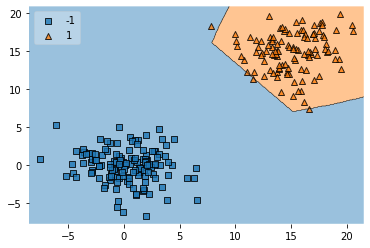

<Figure size 288x288 with 0 Axes>

In [9]:
plot_decision_regions(X_testing, Targets_testing, clf=model, legend=2)
plt.figure(figsize=(4, 4))
plt.show()

### Multi-Class Classification

#### Loss functions: SparseCategorialCrossentropy or CategoricalCrossEntropy
Tensorflow has two potential formats for target values and the selection of the loss defines which is expected.
- SparseCategorialCrossentropy: expects the target to be an integer corresponding to the index. For example, if there are 10 potential target values, y would be between 0 and 9. 
- CategoricalCrossEntropy: Expects the target value of an example to be one-hot encoded where the value at the target index is 1 while the other N-1 entries are zero. An example with 10 potential target values, where the target is 2 would be [0,0,1,0,0,0,0,0,0,0].



In [10]:
num_samples = 1000
train_split = 250
cluster_centers = [(-10, 5), (0, 0), (10, 5)]
num_classes = len(cluster_centers)
loss_function_used = CategoricalCrossentropy(from_logits=True)


def generate_multiclass_blobs(
    num_samples_total, training_split, cluster_centers, num_classes, loss_function_used
):
    X, targets = make_blobs(
        n_samples=num_samples_total,
        centers=cluster_centers,
        n_features=num_classes,
        center_box=(0, 1),
        cluster_std=1.5,
    )
    categorical_targets = to_categorical(targets)
    X_training = X[training_split:, :]
    X_testing = X[:training_split, :]
    Targets_training = categorical_targets[training_split:]
    Targets_testing = categorical_targets[:training_split].astype(np.int32)
    return X_training, Targets_training, X_testing, Targets_testing


X_training, Targets_training, X_testing, Targets_testing = generate_multiclass_blobs(
    num_samples, train_split, cluster_centers, num_classes, loss_function_used
)

In [11]:
X_training.shape, Targets_training.shape, np.unique(Targets_training)

((750, 2), (750, 3), array([0., 1.], dtype=float32))

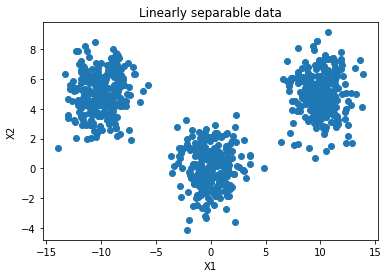

In [12]:
plt.scatter(X_training[:, 0], X_training[:, 1])
plt.title("Linearly separable data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [14]:
feature_vector_shape = X_training.shape[1]
input_shape = (feature_vector_shape,)

model = Sequential()
model.add(
    Dense(
        12, input_shape=input_shape, activation="relu", kernel_initializer="he_uniform"
    )
)
model.add(Dense(8, activation="relu", kernel_initializer="he_uniform"))
model.add(Dense(num_classes, activation="softmax"))

In [15]:
model.compile(
    loss=loss_function_used,
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"],
)
history = model.fit(
    X_training,
    Targets_training,
    epochs=30,
    batch_size=5,
    verbose=1,
    validation_split=0.2,
)

Epoch 1/30
120/120 [==============================] - 2s 6ms/step - loss: 2.9917 - accuracy: 0.1133 - val_loss: 1.1943 - val_accuracy: 0.1933
Epoch 2/30
120/120 [==============================] - 0s 3ms/step - loss: 0.9780 - accuracy: 0.4083 - val_loss: 0.7774 - val_accuracy: 0.7600
Epoch 3/30
120/120 [==============================] - 1s 6ms/step - loss: 0.6635 - accuracy: 0.8117 - val_loss: 0.5101 - val_accuracy: 0.8467
Epoch 4/30
120/120 [==============================] - 1s 7ms/step - loss: 0.4069 - accuracy: 0.8417 - val_loss: 0.3266 - val_accuracy: 0.8400
Epoch 5/30
120/120 [==============================] - 1s 5ms/step - loss: 0.2681 - accuracy: 0.8617 - val_loss: 0.2413 - val_accuracy: 0.8533
Epoch 6/30
120/120 [==============================] - 1s 5ms/step - loss: 0.2056 - accuracy: 0.8950 - val_loss: 0.1938 - val_accuracy: 0.8867
Epoch 7/30
120/120 [==============================] - 1s 4ms/step - loss: 0.1605 - accuracy: 0.9317 - val_loss: 0.1508 - val_accuracy: 0.9133
Epoch 

In [16]:
test_results = model.evaluate(X_testing, Targets_testing, verbose=1)
print(
    f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%")

8/8 [==============================] - 1s 13ms/step - loss: 0.0041 - accuracy: 1.0000
Test results - Loss: 0.0040783812291920185 - Accuracy: 100.0%


[[9.8384237e-01 1.6157677e-02 4.0460378e-12]
 [9.8245990e-01 1.7540116e-02 4.3742241e-12]
 [9.8096150e-01 1.9038454e-02 4.7284811e-12]
 [9.7933793e-01 2.0662073e-02 5.1107621e-12]
 [9.7757894e-01 2.2421079e-02 5.5231479e-12]]


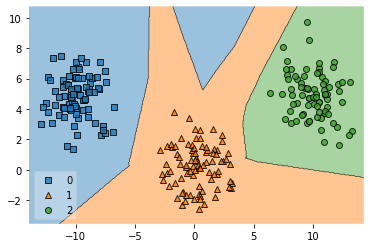

In [18]:
class Onehot2Int(object):

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        y_pred = self.model.predict(X)
        print(y_pred[:5, :])
        return np.argmax(y_pred, axis=1)


# fit keras_model
keras_model_no_ohe = Onehot2Int(model)

# Plot decision boundary
plot_decision_regions(
    X_testing, np.argmax(Targets_testing, axis=1), clf=keras_model_no_ohe, legend=3
)
plt.show()

## Improve implementation of softmax
To numerically stable

In [19]:
num_samples = 1000
train_split = 250
cluster_centers = [(-10, 5), (0, 0), (10, 5)]
num_classes = len(cluster_centers)
loss_function_used = CategoricalCrossentropy(from_logits=True)

feature_vector_shape = X_training.shape[1]
input_shape = (feature_vector_shape,)

model = Sequential()
model.add(
    Dense(
        12, input_shape=input_shape, activation="relu", kernel_initializer="he_uniform"
    )
)
model.add(Dense(8, activation="relu", kernel_initializer="he_uniform"))
model.add(Dense(num_classes, activation="linear"))

In [20]:
model.compile(
    loss=loss_function_used,
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"],
)
history = model.fit(
    X_training,
    Targets_training,
    epochs=30,
    batch_size=5,
    verbose=1,
    validation_split=0.2,
)

Epoch 1/30
120/120 [==============================] - 1s 4ms/step - loss: 0.6579 - accuracy: 0.6717 - val_loss: 0.4476 - val_accuracy: 0.6800
Epoch 2/30
120/120 [==============================] - 0s 2ms/step - loss: 0.4106 - accuracy: 0.7167 - val_loss: 0.3423 - val_accuracy: 0.7467
Epoch 3/30
120/120 [==============================] - 0s 2ms/step - loss: 0.3143 - accuracy: 0.8383 - val_loss: 0.2687 - val_accuracy: 0.8933
Epoch 4/30
120/120 [==============================] - 0s 4ms/step - loss: 0.2402 - accuracy: 0.9317 - val_loss: 0.2086 - val_accuracy: 0.9667
Epoch 5/30
120/120 [==============================] - 0s 3ms/step - loss: 0.1805 - accuracy: 0.9667 - val_loss: 0.1622 - val_accuracy: 0.9800
Epoch 6/30
120/120 [==============================] - 0s 4ms/step - loss: 0.1389 - accuracy: 0.9717 - val_loss: 0.1343 - val_accuracy: 0.9800
Epoch 7/30
120/120 [==============================] - 1s 5ms/step - loss: 0.1106 - accuracy: 0.9817 - val_loss: 0.1041 - val_accuracy: 0.9933
Epoch 

In [21]:
test_results = model.evaluate(X_testing, Targets_testing, verbose=1)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%")

8/8 [==============================] - 1s 9ms/step - loss: 0.0034 - accuracy: 1.0000
Test results - Loss: 0.00338087510317564 - Accuracy: 100.0%


(124416,)


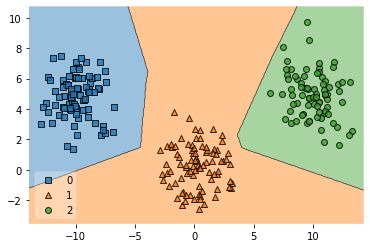

In [22]:
class Onehot2Int(object):
    """_summary_
    this gives you the preferred categories
    Parameters
    ----------
    object : _type_
        _description_
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        y_pred = self.model.predict(X)
        print(np.argmax(y_pred, axis=1).shape)
        return np.argmax(y_pred, axis=1)


# fit keras_model
keras_model_no_ohe = Onehot2Int(model)

# Plot decision boundary
plot_decision_regions(
    X_testing, np.argmax(Targets_testing, axis=1), clf=keras_model_no_ohe, legend=3
)
plt.show()

In [23]:
from tensorflow.keras.datasets import mnist, fashion_mnist
import random

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11501568/11490434 [==============================] - 1s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


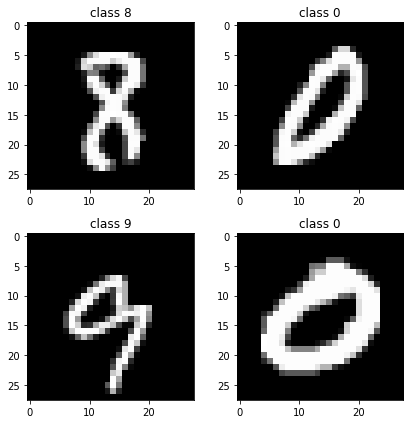

In [24]:
plt.rcParams['figure.figsize'] = (6, 6)

for i in range(4):
    plt.subplot(2, 2, i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("class {}".format(y_train[num]))

plt.tight_layout()

In [25]:
X_train = X_train.reshape(
    X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [26]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

In [28]:
y_train, y_train.shape, y_train.reshape(-1, 1).shape

(array([5, 0, 4, ..., 5, 6, 8], dtype=uint8), (60000,), (60000, 1))

In [29]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
enc.fit(y_train.reshape(-1, 1))
print(enc.categories_)

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)]


In [30]:
y_train_enc = enc.transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))

In [31]:
y_train_enc.shape

(60000, 10)

In [32]:
feature_vector_shape = X_train.shape[1]
input_shape = (feature_vector_shape,)
num_classes = 10
loss_function_used = CategoricalCrossentropy(from_logits=True)
model = Sequential()
model.add(Dense(12, input_shape=input_shape,
          activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_classes, activation='linear'))

In [33]:
model.compile(loss=loss_function_used,
              optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train_enc, epochs=25,
                    batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/25
9600/9600 [==============================] - 53s 5ms/step - loss: 0.4558 - accuracy: 0.8618 - val_loss: 0.2704 - val_accuracy: 0.9219
Epoch 2/25
9600/9600 [==============================] - 56s 6ms/step - loss: 0.2706 - accuracy: 0.9219 - val_loss: 0.2376 - val_accuracy: 0.9310
Epoch 3/25
9600/9600 [==============================] - 77s 8ms/step - loss: 0.2401 - accuracy: 0.9295 - val_loss: 0.2174 - val_accuracy: 0.9358
Epoch 4/25
9600/9600 [==============================] - 136s 14ms/step - loss: 0.2209 - accuracy: 0.9349 - val_loss: 0.2191 - val_accuracy: 0.9356
Epoch 5/25
9600/9600 [==============================] - 105s 11ms/step - loss: 0.2075 - accuracy: 0.9391 - val_loss: 0.2139 - val_accuracy: 0.9351
Epoch 6/25
9600/9600 [==============================] - 99s 10ms/step - loss: 0.1984 - accuracy: 0.9408 - val_loss: 0.2068 - val_accuracy: 0.9403
Epoch 7/25
9600/9600 [==============================] - 110s 11ms/step - loss: 0.1910 - accuracy: 0.9435 - val_loss: 0.2182 -

In [34]:
test_results = model.evaluate(X_test, y_test_enc, verbose=1)
print(
    f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

313/313 [==============================] - 2s 5ms/step - loss: 0.2000 - accuracy: 0.9464
Test results - Loss: 0.20000417530536652 - Accuracy: 94.6399986743927%


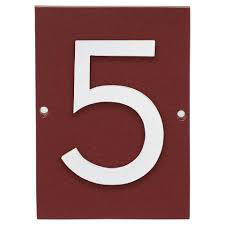

In [35]:
from urllib.request import urlopen
from PIL import Image


image = Image.open("image_name.jpg").convert("RGB")
image

In [36]:
img_rows, img_cols = 28, 28
img = Image.fromarray(np.uint8(image)).convert("L")
img_gray = img.resize((img_rows, img_cols), Image.ANTIALIAS)
img_gray

In [37]:
arr = np.array(img_gray)
arr = arr.reshape((img_cols * img_rows))
arr = np.expand_dims(arr, axis=0)

prediction = model.predict(arr)
np.argmax(prediction)

3

## Convolutional Neural Network (CNN)

In [41]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(
    origin=dataset_url, fname="flower_photos", untar=True
)

data_dir = pathlib.Path(data_dir)

for folder in data_dir.glob("[!LICENSE]*"):
    print("The", folder.name, "folder has", len(
        list(folder.glob("*.jpg"))), "pictures")
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count, "total images")

228827136/228813984 [==============================] - 8s 0us/step
The dandelion folder has 898 pictures
The tulips folder has 799 pictures
The roses folder has 641 pictures
The daisy folder has 633 pictures
The sunflowers folder has 699 pictures
3670 total images


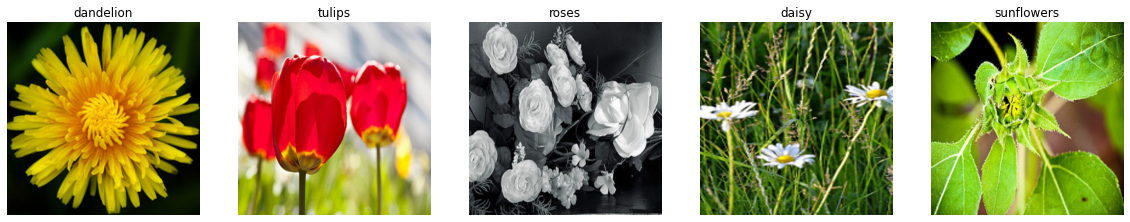

In [68]:
import PIL
from PIL import Image, ImageOps

pics = list()
pics_arr = list()
p_class = list()

img_width = 300
img_height = 300

plt.figure(figsize=(20, 5))
for idx, folder in enumerate(data_dir.glob("[!LICENSE]*")):
    cat = list(data_dir.glob(folder.name + "/*"))
    pic = PIL.Image.open(str(cat[0])).resize((img_width, img_height))
    pic_arr = np.array(pic)
    clss = folder.name

    plt.subplot(1, 5, idx + 1)
    plt.imshow(pic)
    plt.title(clss)
    plt.axis("off")

    pics.append(pic)
    pics_arr.append(pic_arr)
    p_class.append(clss)

In [74]:
# Lets define our custom kernels for the horizontal and vertical gradients
def v_grad(shape, dtype=None):
    # Here we use a single numpy array to define our x gradient kernel
    grad = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).reshape((3, 3, 1, 1))
    # this line is quite important, we are saying we want one 3x3 kernel each for one channel of pixels (grayscale)

    # We check to make sure the shape of our kernel is the correct shape
    # according to the initialization of the Convolutional layer below
    assert grad.shape == shape
    return tf.keras.backend.variable(grad, dtype="float32")


def h_grad(shape, dtype=None):
    grad = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]).reshape((3, 3, 1, 1))

    assert grad.shape == shape
    return tf.keras.backend.variable(grad, dtype="float32")


# We define the input layer of our Neural Network
# to take in an image of 300x300 with 1 channel
# Both our models can share this, as it will not change between the two


input_layer = tf.keras.layers.Input(shape=(img_width, img_height, 1))

h_conv = tf.keras.layers.Conv2D(
    filters=1,  # the number of kernels we are using, kernel and filter are interchangeable terms
    kernel_size=3,
    kernel_initializer=h_grad,
    strides=1,
    padding="valid",
)  # 'valid' means no padding

v_conv = tf.keras.layers.Conv2D(
    filters=1, kernel_size=3, kernel_initializer=v_grad, strides=1, padding="valid"
)


h_model = tf.keras.Sequential([input_layer, h_conv])
v_model = tf.keras.Sequential([input_layer, v_conv])

In [75]:
h_model.summary()
v_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 298, 298, 1)       10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 298, 298, 1)       10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


implement a simple Prewitt (or Sobel) operator in a Neural Network and use it to detect edges in the image

In [80]:
img = pics[2]

# We must convert our RGB image to grayscale, since our CNN models were only designed to apply 1 kernel to 1 channel of input.

gray = ImageOps.grayscale(img)

# We need to add 1 dimension to our input image which represents the batch size
# In this case, we just want to process 1 image.
input_img = np.array(gray).reshape((1, img_width, img_height, 1))

out_d = h_model.layers[0].output_shape[1:]
print(out_d)
# Pass our input image into each model, and return
# the output with a shape of (298,298,1) in variables named `Gy` and `Gx`.
# WRITE YOUR CODE HERE
Gx = h_model.predict(input_img).reshape(out_d)
Gy = v_model.predict(input_img).reshape(out_d)

(298, 298, 1)


In [77]:
# Now that we have the two gradients,
# try computing our gradient magnitude G using numpy
# WRITE YOUR CODE HERE
G = np.sqrt(np.add(np.multiply(Gx, Gx), np.multiply(Gy, Gy)))

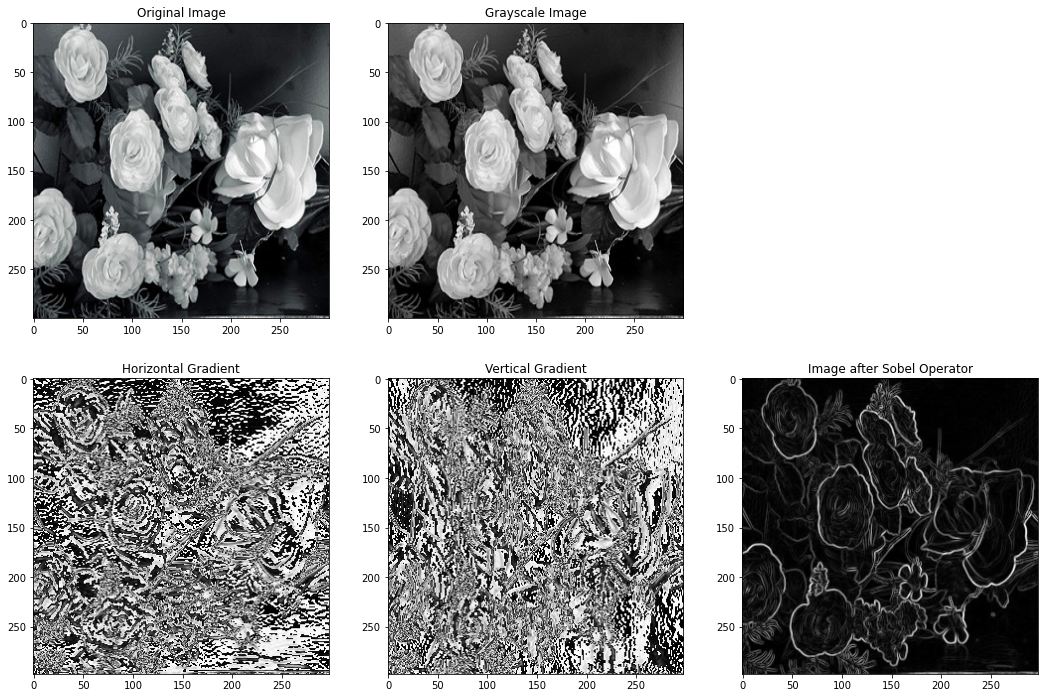

In [81]:
# Lets look at our image at each step of the process!

plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 3, 2)
plt.imshow(gray, cmap=plt.get_cmap("gray"))
plt.title("Grayscale Image")
plt.subplot(2, 3, 4)
plt.imshow(Gx.squeeze().astype("uint8"), cmap=plt.get_cmap("gray"))
plt.title("Horizontal Gradient")
plt.subplot(2, 3, 5)
plt.imshow(Gy.squeeze().astype("uint8"), cmap=plt.get_cmap("gray"))
plt.title("Vertical Gradient")
plt.subplot(2, 3, 6)
plt.imshow(G.squeeze(), cmap=plt.get_cmap("gray"))
plt.title("Image after Sobel Operator")
plt.show()

# Strides and Padding in CNN

Now we set `padding = 'same'` and try different values of `strides` for convolving the two kernels of the Sobel operator over the image. We will use the pre-defined function **sobel**.


As we increase the value of `strides`, the output shape becomes proportionally smaller (as shown in the image titles) but edges detected also become blurry. Therefore, whether to use stride and what value to use may be highly dependent on the specific problem at hand.


In [82]:
# This function will allow us to easily plot data taking in x values, y values, and a title
def sobel(img, strides, padding, activation=None):

    input_layer = tf.keras.layers.Input(shape=(img_height, img_width, 1))

    v_conv = tf.keras.layers.Conv2D(filters=1,
                                    kernel_size=3,
                                    kernel_initializer=v_grad,
                                    strides=strides,
                                    padding=padding,
                                    activation=None)
    h_conv = tf.keras.layers.Conv2D(filters=1,
                                    kernel_size=3,
                                    kernel_initializer=h_grad,
                                    strides=strides,
                                    padding=padding,
                                    activation=None)

    v_model = tf.keras.Sequential([input_layer, v_conv])
    h_model = tf.keras.Sequential([input_layer, h_conv])

    out_d = h_model.layers[0].output_shape[1:]
    Gx = h_model.predict(img).reshape(out_d)
    Gy = v_model.predict(img).reshape(out_d)
    G = np.sqrt(np.add(np.multiply(Gx, Gx), np.multiply(Gy, Gy)))

    return G

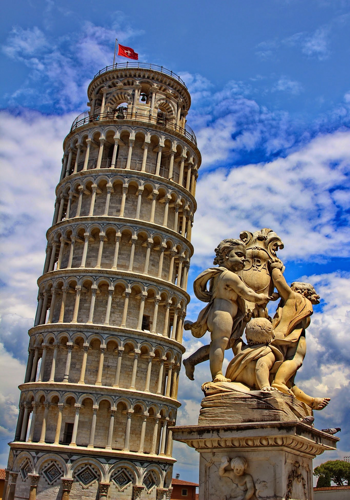

In [83]:
img_width = 350
img_height = 500
img = PIL.Image.open("pisa.jpg").resize((img_width, img_height))
img

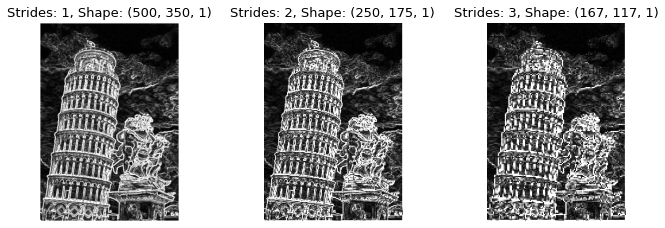

In [85]:
input_img = ImageOps.grayscale(img)
input_img = np.array(input_img).reshape((1, img_height, img_width, 1))

fig, axs = plt.subplots(1, 3, figsize=(9, 10), constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0.1)

for i, ax in enumerate(axs.flat):
    output = (
        sobel(img=input_img, padding="same", strides=i + 1).astype("int").clip(0, 255)
    )

    ax.imshow(output.squeeze(), cmap="gray")
    ax.set_title(f"Strides: {i+1}, Shape: {output.shape}", fontsize=13)
    ax.axis("off")

# Activation functions

Introduce non-linear effects and foces the values of the pixels in the CNN to fall between 0 and 1

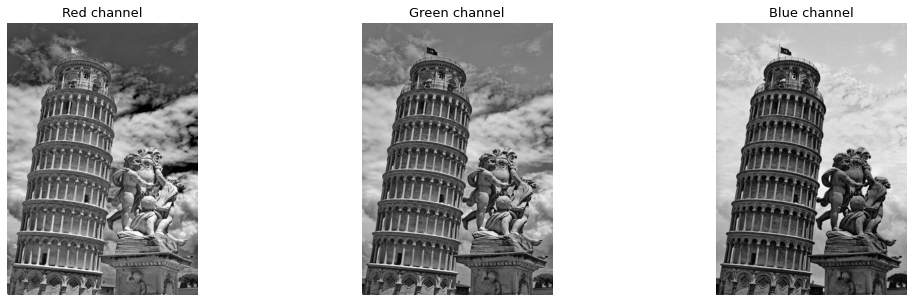

In [86]:
arr = np.array(img)
red_c = arr[:, :, 0]
green_c = arr[:, :, 1]
blue_c = arr[:, :, 2]

channels = [red_c, green_c, blue_c]
names = ["Red", "Green", "Blue"]

plt.figure(figsize=(18, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(channels[i], cmap='gray')
    plt.axis("off")
    plt.title(f"{names[i]} channel", fontsize=13)

In [89]:
kernel = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]]).reshape(3, 3, 1, 1)
b = np.array([0.0])

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(input_shape=(img_height, img_width, 1),
                                 filters=1,
                                 kernel_size=3,
                                 padding='same',
                                 activation='relu'
                                 ))
model.set_weights([kernel, b])
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 500, 350, 1)       10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


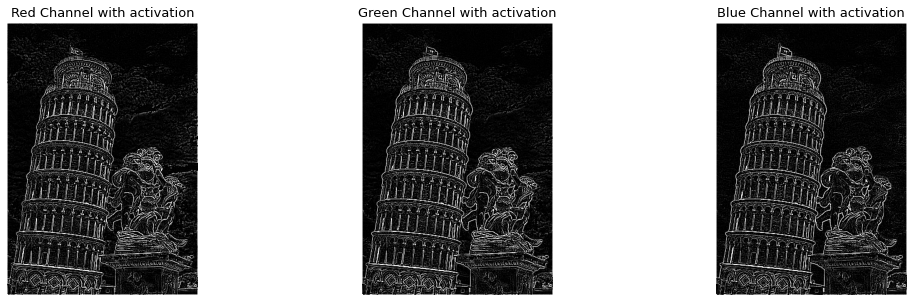

In [90]:
acts = []
plt.figure(figsize=(18, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)

    # loop through each channel
    input_ = channels[i].reshape((1, img_height, img_width, 1))
    act = model.predict(input_).squeeze(
        0).squeeze(2).astype('int').clip(0, 255)
    # store the result in a list called "acts"
    acts.append(act)

    plt.imshow(act, cmap='gray')
    plt.axis("off")
    plt.title(f"{names[i]} Channel with activation", fontsize=13)

(-0.5, 349.5, 499.5, -0.5)

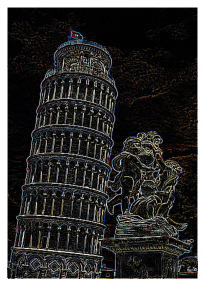

In [91]:
# Now it's time to stack the three channels back together and see what our edge detection tool did for us!

arr_hat = np.dstack((acts[0], acts[1], acts[2]))

plt.figure(figsize=(10, 5))
plt.imshow(arr_hat)
plt.axis("off")

## Pooling

 It is a form of non-linear down-sampling to progressively **reduce the spatial size of the representation**, to **reduce the number of parameters**, **memory footprint and amount of computation in the network**, and hence to also **control overfitting**.

In [92]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print("MNIST downloaded!")
print("Train set shape:", X_train.shape)

MNIST downloaded!
Train set shape: (60000, 28, 28)


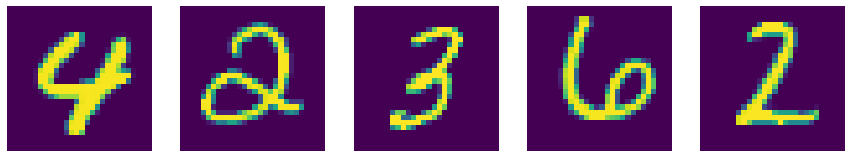

In [93]:
images = []
plt.figure(figsize=(15, 3))
for i in range(5):
    img = X_train[np.random.randint(0, 60000)].astype('float')
    images.append(img)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

max_pool and avg_pool tool to perform pooling on these five images and see how their results appear differently. in max pooling the prominent features are highlighted more, whereas in average pooling it gives a smoother image retaining the complete features in the image.

We cannot say that one particular pooling method is better than the other generally. The choice of pooling operation should be made based on the problem at hand.


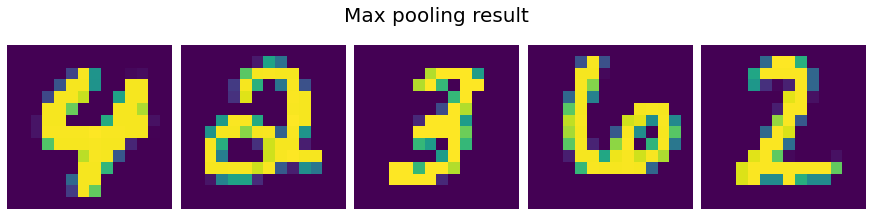

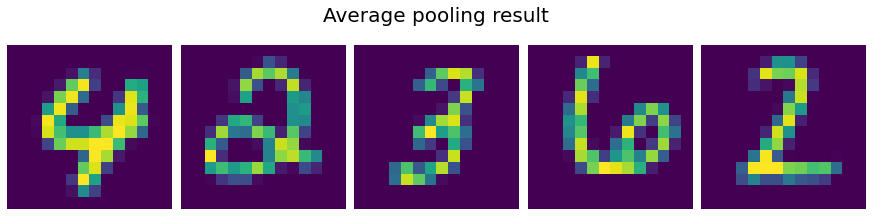

In [94]:
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D

max_pool = tf.keras.Sequential([MaxPooling2D(pool_size=(2, 2))])
avg_pool = tf.keras.Sequential([AveragePooling2D(pool_size=(2, 2))])

fig1, axs1 = plt.subplots(1, 5, figsize=(12, 3), constrained_layout=True)
fig2, axs2 = plt.subplots(1, 5, figsize=(12, 3), constrained_layout=True)
fig1.suptitle("Max pooling result", fontsize=20)
fig2.suptitle("Average pooling result", fontsize=20)

for img, ax1, ax2 in zip(images, axs1.flat, axs2.flat):
    input_ = img.reshape(1, 28, 28, 1)
    ax1.imshow(max_pool.predict(input_).squeeze(0).squeeze(2))
    ax1.axis('off')
    ax2.imshow(avg_pool.predict(input_).squeeze(0).squeeze(2))
    ax2.axis('off')

In [95]:
from tensorflow.keras import layers, datasets


def load_cifar10():
    (trainX, trainY), (testX, testY) = datasets.cifar10.load_data()

    trainX = trainX.astype('float32') / 255
    testX = testX.astype('float32') / 255

    trainY = to_categorical(trainY)
    testY = to_categorical(testY)

    return trainX, trainY, testX, testY


X_train, y_train, X_test, y_test = load_cifar10()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

170508288/170498071 [==============================] - 15s 0us/step


((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

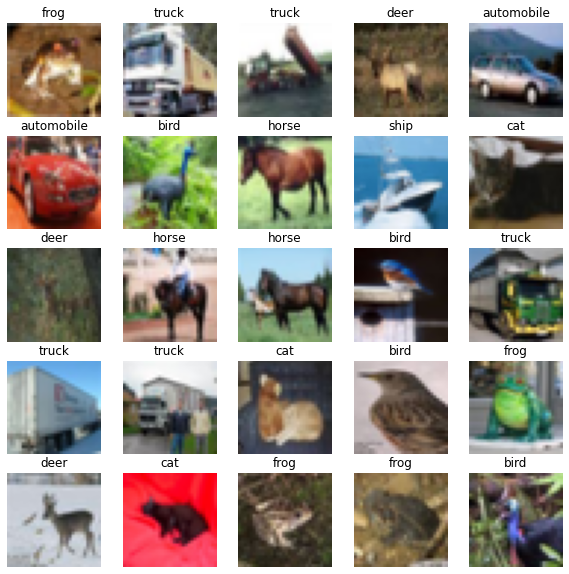

In [96]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[np.where(y_train[i] == 1)[0][0]])
    plt.axis("off")

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                 input_shape=(32, 32, 3))) 
# Don't forget specifying input_shape in the 1st Conv2D layer of your CNN

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

## Receptive field
Describes how much information is learned by each layer, the bigger the better and is influenced by
*   Number of convolution layers: making a deeper network increases field size linearly by kernel size.
*   Stride: as a method of sub-sampling, the higher the stride value, the fewer input pixels shared between neighboring features, the bigger the receptive field as we add more layers.
*   Pooling: this is also a way of sub-sampling that increases the size multiplicatively. It causes resolution loss as the relationship between the original input features isn't fully retained.
*   Dilation rate: introduces spaces in between kernel values such that they aren't applied to adjacent samples. Increases size exponentially without loss of resolution like sub-sampling techniques (not covered).


### Flattening
Flattening is the process of converting input into a 1D array for the next layer. The reason behind this is that our final task - classification - isn't compatible with higher dimensional input, considering we desire a class label as output.

The way that tensors are flattened is quite simple. We desire an output of the shape Nx1, where N is the number of features in the input. For 2-dimensional input, this is straightforward - a tensor of the shape 28x28 will flatten into a single vector of 784x1.


## Builidng a complete CNN and prediction

In [99]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(
    origin=dataset_url, fname="flower_photos", untar=True
)

data_dir = pathlib.Path(data_dir)

for folder in data_dir.glob("[!LICENSE]*"):
    print("The", folder.name, "folder has", len(list(folder.glob("*.jpg"))), "pictures")
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count, "total images")

The dandelion folder has 898 pictures
The tulips folder has 799 pictures
The roses folder has 641 pictures
The daisy folder has 633 pictures
The sunflowers folder has 699 pictures
3670 total images


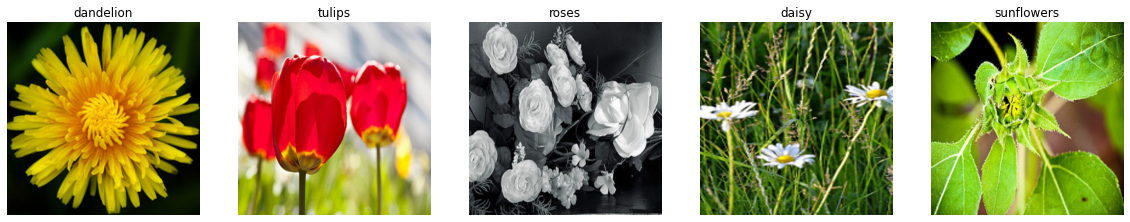

In [103]:
pics = list()
pics_arr = list()
p_class = list()

img_width = 300
img_height = 300

plt.figure(figsize=(20, 5))
for idx, folder in enumerate(data_dir.glob("[!LICENSE]*")):
    cat = list(data_dir.glob(folder.name + "/*"))
    pic = PIL.Image.open(str(cat[0])).resize((img_width, img_height))
    pic_arr = np.array(pic)
    clss = folder.name

    plt.subplot(1, 5, idx + 1)
    plt.imshow(pic)
    plt.title(clss)
    plt.axis("off")

    pics.append(pic)
    pics_arr.append(pic_arr)
    p_class.append(clss)

In [124]:

img_width = 150
img_height = 150

batch_size = 64
epochs = 10

#  create a train set using the ImageDataGenerator and flow_from_directory functions from keras.utils.
train_gen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255.0,
    width_shift_range=0.2,  # 0.1
    height_shift_range=0.2,  # 0.1
    horizontal_flip=True,
)
train_set = train_gen.flow_from_directory(
    directory=data_dir,
    seed=10,
    class_mode="sparse",
    batch_size=batch_size,
    shuffle=True,
    target_size=(img_height, img_width),
    subset="training",
)

Found 2939 images belonging to 5 classes.


In [125]:
val_gen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
val_set = val_gen.flow_from_directory(
    directory=data_dir,
    seed=10,
    class_mode="sparse",
    batch_size=batch_size,
    shuffle=True,
    target_size=(img_height, img_width),
    subset="validation",
)

Found 731 images belonging to 5 classes.


In [126]:
class_names = {y: x for x, y in val_set.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [127]:
classifier = Sequential()

classifier.add(
    Conv2D(
        32,
        (5, 5),
        padding="same",
        input_shape=(img_width, img_height, 3),
        activation="relu",
    )
)
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


classifier.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
classifier.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

classifier.build((1, img_width, img_height, 3))
classifier.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 37, 37, 32)        18464     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 18, 18, 32)      

In [128]:
classifier.add(Flatten())
classifier.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 37, 37, 32)        18464     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 18, 18, 32)      

In [129]:
classifier.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [130]:
classifier.fit(
    train_set,
    validation_data=val_set,
    epochs=epochs
)

Epoch 1/10
46/46 [==============================] - 166s 4s/step - loss: 4.4226 - accuracy: 0.1259 - val_loss: 2.5067 - val_accuracy: 0.2709
Epoch 2/10
46/46 [==============================] - 156s 3s/step - loss: 1.8248 - accuracy: 0.2576 - val_loss: 1.8552 - val_accuracy: 0.2421
Epoch 3/10
46/46 [==============================] - 146s 3s/step - loss: 1.7098 - accuracy: 0.2617 - val_loss: 1.5832 - val_accuracy: 0.2886
Epoch 4/10
46/46 [==============================] - 167s 4s/step - loss: 1.8995 - accuracy: 0.2518 - val_loss: 1.6404 - val_accuracy: 0.2955
Epoch 5/10
46/46 [==============================] - 168s 4s/step - loss: 1.6033 - accuracy: 0.2542 - val_loss: 1.5823 - val_accuracy: 0.2613
Epoch 6/10
46/46 [==============================] - 164s 4s/step - loss: 1.5926 - accuracy: 0.2685 - val_loss: 1.5676 - val_accuracy: 0.2859
Epoch 7/10
46/46 [==============================] - 174s 4s/step - loss: 1.5777 - accuracy: 0.2732 - val_loss: 1.5473 - val_accuracy: 0.3037
Epoch 8/10
46

In [131]:
for layer in classifier.layers:
    if 'conv2d' in layer.name:
        kernels, biases = layer.get_weights()
        print(
            f"layer name: {layer.name}, num of kernels: {kernels.shape[-1]}, kernel shape: {kernels.shape[:2]}, kernel depth: {kernels.shape[2]}")

layer name: conv2d_34, num of kernels: 32, kernel shape: (5, 5), kernel depth: 3
layer name: conv2d_35, num of kernels: 64, kernel shape: (3, 3), kernel depth: 32
layer name: conv2d_36, num of kernels: 32, kernel shape: (3, 3), kernel depth: 64
layer name: conv2d_37, num of kernels: 32, kernel shape: (3, 3), kernel depth: 32


Let's try to see how the layers look so far when applied on a sample image without training (call the `predict` method directly on the **img_tensor**.


(300, 300, 3)


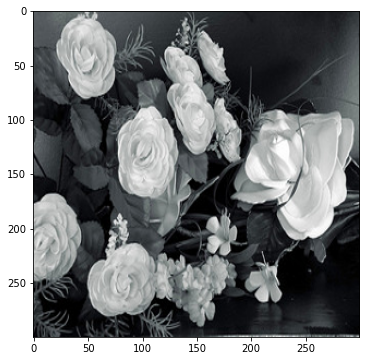

In [144]:
# display the sample image
img_tensor = np.array(pics_arr[2], dtype="int")
print(img_tensor.shape)
plt.imshow(img_tensor)

Text(0.5, 1.0, 'Predicted class is: sunflowers')

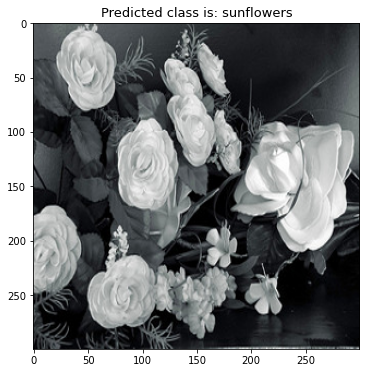

In [145]:
img_tensor = np.expand_dims(img_tensor, axis=0)

y = classifier.predict(img_tensor)
label = class_names[np.argmax(y)]

plt.imshow(img_tensor.reshape((300, 300, 3)).astype("uint8"))
plt.title(f"Predicted class is: {label}", fontsize=13)

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

### Dense Layers

Before we start making predictions, there's one last layer(s) in the neural network - dense layers. The first fully connected layer essentially uses the features we learned from previous convolutional and pooling layers to make predictions for a given image. It takes a flattened 1D array as input, calculates their weighted average, and then applies an activation function on it. As a result, each output is a combination of all the input features, making this layer "fully-connected".

The last dense layer must have the softmax activation function when we have more than two classes because it will output probabilities of each label class and select the one with the highest probability as the final class of the input image.


In [148]:
def load_cifar10():
    (trainX, trainY), (testX, testY) = datasets.cifar10.load_data()

    trainX = trainX.astype("float32") / 255
    testX = testX.astype("float32") / 255

    trainY = to_categorical(trainY)
    testY = to_categorical(testY)

    return trainX, trainY, testX, testY


X_train, y_train, X_test, y_test = load_cifar10()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [150]:
# Let's build a CNN using Keras' Sequential capabilities

model_1 = Sequential()


# 5x5 convolution with 2x2 stride and 32 filters
model_1.add(
    Conv2D(32, (5, 5), strides=(2, 2), padding="same", input_shape=X_train.shape[1:])
)
model_1.add(Activation("relu"))

# Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2)))
model_1.add(Activation("relu"))

# 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation("relu"))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation("softmax"))

model_1.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
activation (Activation)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 6, 6, 32)          25632     
_________________________________________________________________
activation_1 (Activation)    (None, 6, 6, 32)          0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 288)             

In [151]:
batch_size = 32

# initiate RMSprop optimizer
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

model_1.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=15,
            validation_data=(X_test, y_test),
            shuffle=True)

Epoch 1/15
1563/1563 [==============================] - 42s 26ms/step - loss: 1.7257 - accuracy: 0.3681 - val_loss: 1.4348 - val_accuracy: 0.4887
Epoch 2/15
1563/1563 [==============================] - 43s 28ms/step - loss: 1.4456 - accuracy: 0.4803 - val_loss: 1.2814 - val_accuracy: 0.5366
Epoch 3/15
1563/1563 [==============================] - 48s 31ms/step - loss: 1.3301 - accuracy: 0.5245 - val_loss: 1.1786 - val_accuracy: 0.5832
Epoch 4/15
1563/1563 [==============================] - 51s 33ms/step - loss: 1.2592 - accuracy: 0.5529 - val_loss: 1.1433 - val_accuracy: 0.6014
Epoch 5/15
1563/1563 [==============================] - 47s 30ms/step - loss: 1.2025 - accuracy: 0.5733 - val_loss: 1.1964 - val_accuracy: 0.5847
Epoch 6/15
1563/1563 [==============================] - 32s 20ms/step - loss: 1.1685 - accuracy: 0.5886 - val_loss: 1.2375 - val_accuracy: 0.5658
Epoch 7/15
1563/1563 [==============================] - 31s 20ms/step - loss: 1.1467 - accuracy: 0.5967 - val_loss: 1.0917 -

In [154]:
# Let's build a CNN using Keras' Sequential capabilities

model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model_2.add(Activation("relu"))
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation("relu"))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding="same"))
model_2.add(Activation("relu"))
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation("relu"))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation("relu"))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation("softmax"))

model_2.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_5 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 15, 15, 64)      

In [155]:
# initiate RMSprop optimizer
opt_2 = tf.keras.optimizers.RMSprop(lr=0.0005)

# Let's train the model using RMSprop
model_2.compile(loss="categorical_crossentropy", optimizer=opt_2, metrics=["accuracy"])


run = model_2.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=5,
    validation_data=(X_test, y_test),
    shuffle=True,
)

Epoch 1/5
1563/1563 [==============================] - 363s 200ms/step - loss: 1.5752 - accuracy: 0.4288 - val_loss: 1.3288 - val_accuracy: 0.5233
Epoch 2/5
1563/1563 [==============================] - 215s 137ms/step - loss: 1.1865 - accuracy: 0.5800 - val_loss: 1.0384 - val_accuracy: 0.6249
Epoch 3/5
1563/1563 [==============================] - 177s 113ms/step - loss: 1.0269 - accuracy: 0.6402 - val_loss: 0.9116 - val_accuracy: 0.6821
Epoch 4/5
1563/1563 [==============================] - 116s 74ms/step - loss: 0.9316 - accuracy: 0.6777 - val_loss: 0.9171 - val_accuracy: 0.6875
Epoch 5/5
1563/1563 [==============================] - 121s 77ms/step - loss: 0.8777 - accuracy: 0.6960 - val_loss: 0.7835 - val_accuracy: 0.7324


Text(0.5, 1.0, 'Accuracy over iterations')

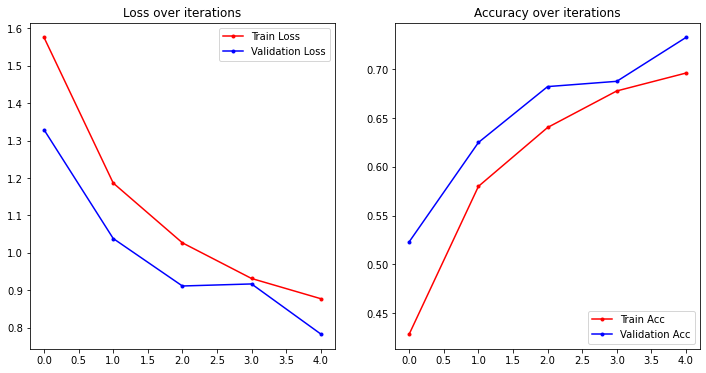

In [159]:
n = len(run.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run.history["loss"]), "r.", label="Train Loss", ls="-")
ax.plot(range(n), (run.history["val_loss"]),
        "b.", label="Validation Loss", ls="-")
ax.legend()
ax.set_title("Loss over iterations")

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run.history["accuracy"]), "r.", label="Train Acc", ls="-")
ax.plot(range(n), (run.history["val_accuracy"]),
        "b.", label="Validation Acc", ls="-")
ax.legend(loc="lower right")
ax.set_title("Accuracy over iterations")

# Transfer Learning

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print("MNIST downloaded!")
print("Train set shape:", X_train.shape)

MNIST downloaded!
Train set shape: (60000, 28, 28)


In [4]:
np.unique(y_train), K.image_data_format()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), 'channels_last')

In [5]:
# set some more parameters
img_rows, img_cols = 28, 28
filters = 32
pool_size = 2
kernel_size = 3

# set some parameters
batch_size = 128
num_classes = 5
epochs = 5

# This just handles some variability in how the input data is loaded
if K.image_data_format() == "channels_first":
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)

In [6]:
input_shape

(28, 28, 1)

In [177]:
# Define the "feature" layers.  These are the early layers that we expect will "transfer"
# to a new problem.  We will freeze these layers during the fine-tuning process

feature_layers = [
    Conv2D(filters, kernel_size, padding="valid", input_shape=input_shape),
    Activation("relu"),
    Conv2D(filters, kernel_size),
    Activation("relu"),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

In [178]:
# Define the "classification" layers.  These are the later layers that predict the specific classes from the features
# learned by the feature layers.  This is the part of the model that needs to be re-trained for a new problem

classification_layers = [
    Dense(128),
    Activation("relu"),
    Dropout(0.5),
    Dense(num_classes),
    Activation("softmax"),
]

In [179]:
# We create our model by combining the two sets of layers as follows
model = Sequential(feature_layers + classification_layers)

# Let's take a look
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_16 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4608)            

In [183]:
# Now, let's train our model on the digits 5,6,7,8,9
# create two datasets: one with digits below 5 and one with 5 and above
x_train_lt5 = X_train[y_train < 5]
y_train_lt5 = y_train[y_train < 5]
x_test_lt5 = X_test[y_test < 5]
y_test_lt5 = y_test[y_test < 5]

x_train_gte5 = X_train[y_train >= 5]
y_train_gte5 = y_train[y_train >= 5] - 5
x_test_gte5 = X_test[y_test >= 5]
y_test_gte5 = y_test[y_test >= 5] - 5


def train_model(model, train, test, num_classes):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    x_train /= 255
    x_test /= 255
    print("x_train shape:", x_train.shape)
    print(x_train.shape[0], "train samples")
    print(x_test.shape[0], "test samples")

    # convert class vectors to binary class matrices
    y_train = tf.keras.utils.to_categorical(train[1], num_classes)
    y_test = tf.keras.utils.to_categorical(test[1], num_classes)

    model.compile(
        loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"]
    )

    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test),
    )

    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test score:", score[0])
    print("Test accuracy:", score[1])


train_model(
    model, (x_train_gte5, y_train_gte5), (x_test_gte5, y_test_gte5), num_classes
)

x_train shape: (29404, 28, 28, 1)
29404 train samples
4861 test samples
Epoch 1/5
230/230 [==============================] - 59s 254ms/step - loss: 1.6069 - accuracy: 0.2198 - val_loss: 1.5980 - val_accuracy: 0.2520
Epoch 2/5
230/230 [==============================] - 61s 266ms/step - loss: 1.5940 - accuracy: 0.2771 - val_loss: 1.5826 - val_accuracy: 0.3758
Epoch 3/5
230/230 [==============================] - 47s 204ms/step - loss: 1.5782 - accuracy: 0.3431 - val_loss: 1.5659 - val_accuracy: 0.5415
Epoch 4/5
230/230 [==============================] - 62s 271ms/step - loss: 1.5626 - accuracy: 0.4040 - val_loss: 1.5474 - val_accuracy: 0.6641
Epoch 5/5
230/230 [==============================] - 68s 294ms/step - loss: 1.5460 - accuracy: 0.4608 - val_loss: 1.5264 - val_accuracy: 0.7171
Test score: 1.5263938903808594
Test accuracy: 0.7171363830566406


### Freezing Layers
tensorflow.Keras allows layers to be "frozen" during the training process.  That is, some layers would have their weights updated during the training process, while others would not.  This is a core part of transfer learning, the ability to train just the last one or several layers.

Note also, that a lot of the training time is spent "back-propagating" the gradients back to the first layer.  Therefore, if we only need to compute the gradients back a small number of layers, the training time is much quicker per iteration.  This is in addition to the savings gained by being able to train on a smaller data set.


In [184]:
# Freeze only the feature layers
for l in feature_layers:
    l.trainable = False

In [185]:
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_16 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4608)            

In [186]:
train_model(model, (x_train_lt5, y_train_lt5), (x_test_lt5, y_test_lt5), num_classes)

x_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples
Epoch 1/5
240/240 [==============================] - 19s 75ms/step - loss: 1.5895 - accuracy: 0.2857 - val_loss: 1.5761 - val_accuracy: 0.3940
Epoch 2/5
240/240 [==============================] - 23s 94ms/step - loss: 1.5692 - accuracy: 0.3503 - val_loss: 1.5536 - val_accuracy: 0.4902
Epoch 3/5
240/240 [==============================] - 24s 102ms/step - loss: 1.5490 - accuracy: 0.4131 - val_loss: 1.5305 - val_accuracy: 0.5820
Epoch 4/5
240/240 [==============================] - 24s 99ms/step - loss: 1.5264 - accuracy: 0.4827 - val_loss: 1.5065 - val_accuracy: 0.6493
Epoch 5/5
240/240 [==============================] - 18s 75ms/step - loss: 1.5047 - accuracy: 0.5381 - val_loss: 1.4817 - val_accuracy: 0.7064
Test score: 1.4817352294921875
Test accuracy: 0.7063630819320679


In [22]:
dataframe = pd.read_csv("sonar.all-data", header=None)

dataset = dataframe.values

dataset.shape

(208, 61)

In [23]:
X = dataset[:, :60].astype(float)
y = dataset[:, 60]

In [24]:
# encode labels
le = LabelEncoder()
encoded_y = le.fit(y).transform(y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, encoded_y, test_size=0.20, random_state=42)

## The Sequential Model API

The Sequential model API groups a linear stack of layers into a tf.keras.Model. It doesn't allow you to create models that share layers, have branches, multiple inputs, or multiple outputs. It does provide training and inference features on this model.

In [26]:
def baseline_model():
    model = Sequential()
    model.add(Dense(60, activation='relu', input_shape=(60,)))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


estimator = baseline_model()
estimator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                3660      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 7,381
Trainable params: 7,381
Non-trainable params: 0
_________________________________________________________________


In [27]:
estimator.fit(X_train, y_train, epochs=10, batch_size=16)

Epoch 1/10
11/11 [==============================] - 3s 6ms/step - loss: 0.7210 - accuracy: 0.5181
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.6735 - accuracy: 0.6506
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.6669 - accuracy: 0.6145
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.6309 - accuracy: 0.7711
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.6151 - accuracy: 0.8253
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.5969 - accuracy: 0.7410
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.5774 - accuracy: 0.8012
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.5552 - accuracy: 0.8313
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.5363 - accuracy: 0.8072
Epoch 10/10
11/11 [==============================] - 0s 7ms/step - loss: 0.5247 - accuracy: 0.7831


In [29]:
y_pred = estimator.predict(X_test)
print(y_pred[:5])
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
metrics.accuracy_score(y_pred, y_test)

[[0.31592584]
 [0.71154076]
 [0.5168061 ]
 [0.60252106]
 [0.30614543]]


0.8809523809523809

## The Functional Model API


In [30]:
def functional_model():
    inputs = Input(shape=(60,))
    layer1 = Dense(60, activation='relu')(inputs)
    layer2 = Dense(60, activation='relu')(layer1)
    outputs = Dense(1, activation='sigmoid')(layer2)

    model = Model(inputs, outputs)

    # Compile model, write code below
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


functional_estimator = functional_model()
estimator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                3660      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 7,381
Trainable params: 7,381
Non-trainable params: 0
_________________________________________________________________


In [31]:
functional_estimator.fit(X_train, y_train, epochs=10, batch_size=16)

Epoch 1/10
11/11 [==============================] - 2s 6ms/step - loss: 0.6843 - accuracy: 0.5241
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.6867
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.6360 - accuracy: 0.7410
Epoch 4/10
11/11 [==============================] - 0s 14ms/step - loss: 0.6166 - accuracy: 0.7048
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.5939 - accuracy: 0.7048
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.5725 - accuracy: 0.7349
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.5550 - accuracy: 0.7108
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.5388 - accuracy: 0.7410
Epoch 9/10
11/11 [==============================] - 0s 12ms/step - loss: 0.5220 - accuracy: 0.8012
Epoch 10/10
11/11 [==============================] - 0s 8ms/step - loss: 0.4996 - accuracy: 0.7651


In [32]:
y_pred = functional_estimator.predict(X_test)
print(y_pred[:5])
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
metrics.accuracy_score(y_pred, y_test)

[[0.30917498]
 [0.74677294]
 [0.4439359 ]
 [0.61802214]
 [0.25645047]]


0.8809523809523809

## Model Subclassing

In [33]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(60, activation='relu')
        self.dense2 = Dense(60, activation='relu')
        self.dense3 = Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)


def subclass_model():
    inputs = Input(shape=(60,))
    mymodel = MyModel()
    outputs = mymodel.call(inputs)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


subclass_estimator = subclass_model()
subclass_estimator.fit(X_train, y_train, epochs=15, batch_size=16)

Epoch 1/15
11/11 [==============================] - 3s 5ms/step - loss: 0.6900 - accuracy: 0.4639
Epoch 2/15
11/11 [==============================] - 0s 5ms/step - loss: 0.6646 - accuracy: 0.5602
Epoch 3/15
11/11 [==============================] - 0s 7ms/step - loss: 0.6355 - accuracy: 0.7229
Epoch 4/15
11/11 [==============================] - 0s 8ms/step - loss: 0.6178 - accuracy: 0.7711
Epoch 5/15
11/11 [==============================] - 0s 7ms/step - loss: 0.5886 - accuracy: 0.7169
Epoch 6/15
11/11 [==============================] - 0s 10ms/step - loss: 0.5593 - accuracy: 0.7651
Epoch 7/15
11/11 [==============================] - 0s 14ms/step - loss: 0.5280 - accuracy: 0.7771
Epoch 8/15
11/11 [==============================] - 0s 11ms/step - loss: 0.5039 - accuracy: 0.8012
Epoch 9/15
11/11 [==============================] - 0s 8ms/step - loss: 0.4807 - accuracy: 0.7892
Epoch 10/15
11/11 [==============================] - 0s 8ms/step - loss: 0.4644 - accuracy: 0.8072
Epoch 11/15
11/1

In [34]:
y_pred = subclass_estimator.predict(X)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
metrics.accuracy_score(y_pred, encoded_y)

0.8846153846153846

## Transfer Learning example

In [35]:
! wget https://jupyterlab-6-labs-prod-jupyterlab-us-east-0.labs.cognitiveclass.ai/hub/user-redirect/lab/tree/labs/Module3/L2/o-vs-r-split ./

--2024-02-09 12:11:13--  https://jupyterlab-6-labs-prod-jupyterlab-us-east-0.labs.cognitiveclass.ai/hub/user-redirect/lab/tree/labs/Module3/L2/o-vs-r-split
Resolving jupyterlab-6-labs-prod-jupyterlab-us-east-0.labs.cognitiveclass.ai (jupyterlab-6-labs-prod-jupyterlab-us-east-0.labs.cognitiveclass.ai)... 23.51.109.191, 2a02:26f0:9100:1097::1d91, 2a02:26f0:9100:1089::1d91
Connecting to jupyterlab-6-labs-prod-jupyterlab-us-east-0.labs.cognitiveclass.ai (jupyterlab-6-labs-prod-jupyterlab-us-east-0.labs.cognitiveclass.ai)|23.51.109.191|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: /hub/login?next=%2Fhub%2Fuser-redirect%2Flab%2Ftree%2Flabs%2FModule3%2FL2%2Fo-vs-r-split [following]
--2024-02-09 12:11:13--  https://jupyterlab-6-labs-prod-jupyterlab-us-east-0.labs.cognitiveclass.ai/hub/login?next=%2Fhub%2Fuser-redirect%2Flab%2Ftree%2Flabs%2FModule3%2FL2%2Fo-vs-r-split
Reusing existing connection to jupyterlab-6-labs-prod-jupyterlab-us-east-0.labs.cog

## Autoencoders

In [11]:
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:


(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [3]:
x_train = x_train.astype("float") / 255.0
x_test = x_test.astype("float") / 255.0

In [7]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


In [8]:
s = StandardScaler().fit(x_train_flat)
x_train_scaled = s.transform(x_train_flat)

Variance explained with 784 components: 1.0


Text(0, 0.5, 'Proportion of variance explained')

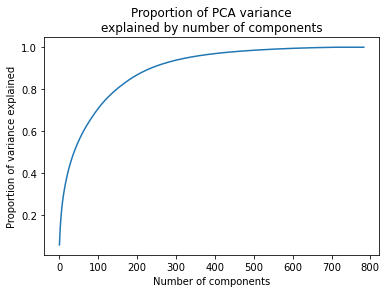

In [12]:
def mnist_pca(x_data, n_components):
    pca = PCA(n_components=n_components)

    fit_pca = pca.fit(x_data)

    print(
        "Variance explained with {0} components:".format(n_components),
        round(sum(fit_pca.explained_variance_ratio_), 2),
    )

    return fit_pca, fit_pca.transform(x_data)


pca_full, mnist_data_full = mnist_pca(x_train_scaled, 784)

plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained")

We need about 250 components to explain 90% of the variance in the data!

For visualization purposes, let's extract just two components and plot them:


In [13]:
pca_2, mnist_data_2 = mnist_pca(x_train_scaled, 2)

mnist_data_2.shape

Variance explained with 2 components: 0.1


(60000, 2)

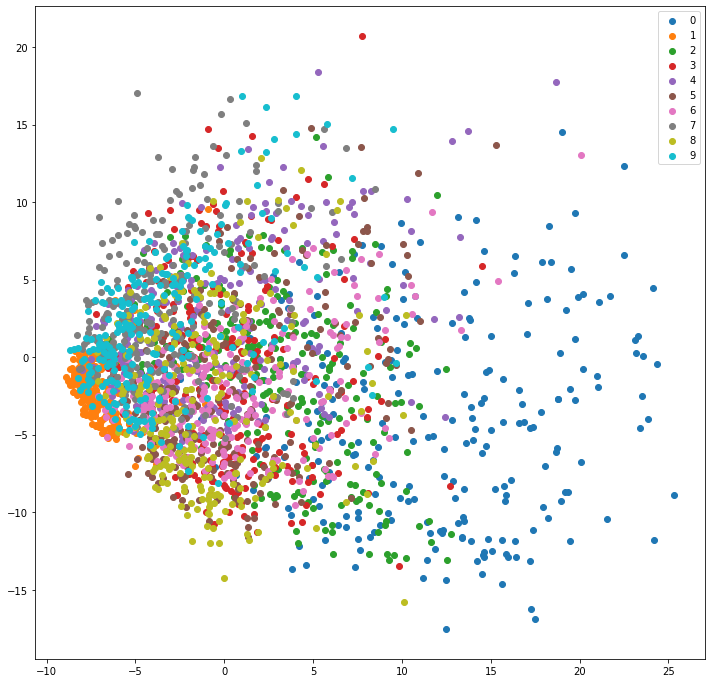

In [14]:
num_images_per_class = 250
fig = plt.figure(figsize=(12, 12))
for number in list(range(10)):
    mask = y_train == number
    x_data = mnist_data_2[mask, 0][:num_images_per_class]
    y_data = mnist_data_2[mask, 1][:num_images_per_class]
    plt.scatter(x_data, y_data, label=number, alpha=1)
plt.legend()

We can already see that the latent features PCA is learning _somewhat_ disentangle the features here, and a neural network could certainly help with this.

### Scoring PCA


In [15]:
pca_64, mnist_data_64 = mnist_pca(x_train_scaled, 64)

s = StandardScaler().fit(x_test_flat)
x_test_scaled = s.transform(x_test_flat)


x_test_flat_64 = pca_64.transform(x_test_scaled)
x_test_reconstructed_64 = pca_64.inverse_transform(x_test_flat_64)

Variance explained with 64 components: 0.6


In [16]:
x_test_reconstructed_64.shape

(10000, 784)

In [17]:
true = x_test_scaled
reconstructed = x_test_reconstructed_64


def mse_reconstruction(true, reconstructed):
    return np.sum(np.power(true - reconstructed, 2) / true.shape[1])


mse_reconstruction(true, reconstructed)

3167.752737612286